In [518]:
library(dplyr)
library(lme4)
library(nlme)
library(purrr)
library(performance)
library(tibble)
library(MuMIn)
library(here)
library(reactablefmtr)
library(emmeans)
library(car)
library(ggplot2)
library(modelr)
require(vegan)
require(knitr)
require(ggpubr)
library(ggeffects)
library(janitor)
library(sjPlot)
library(factoextra)

In [519]:
setwd(here::here())

In [627]:
# Load all joined dataset
source("./scripts/code_join_data_full_dataset.R")

In [628]:
# Load custom made functions
source("./R/functions_models.R")
source("./R/function_plots.R")
source("./R/function_validation_plots.R")
source("./R/function_for_inference_emmeans_and_percentage_diff.R")


In [599]:
# set plot dimensions
options(repr.plot.width = 15)
options(repr.plot.height = 15)

__For running each peice of code press shift + Enter__

# __Q3:How do functional traits, treatment, and N-fixing status interact to influence seedling-level growth rates and biomass accumulation?__


## PCA


In [629]:
# Select variables that are going to be used in the model
data_for_models <-
    data_for_models %>%

    clean_names() %>%
    # Select columns needed for regression
    dplyr::select(spcode, treatment, nfixer, init_height,

                  # Performance measures
                  total_biomass, rgr, root_shoot_ratio,

                  # physiology traits
                  amax, gs, wue,pnue,d13c,

                  # Leaf traits
                  narea_g_m2) %>%
    clean_names()

In [630]:
# Center and scale by 2 as Gelman et al 2008

data_traits_scaled <-
    data_for_models %>%
        dplyr::select(-c(total_biomass, rgr, root_shoot_ratio, init_height)) %>%
        mutate(across(where(is.numeric), scale))

In [631]:
pca_traits <- princomp(data_traits_scaled[,c(4:ncol(data_traits_scaled))])

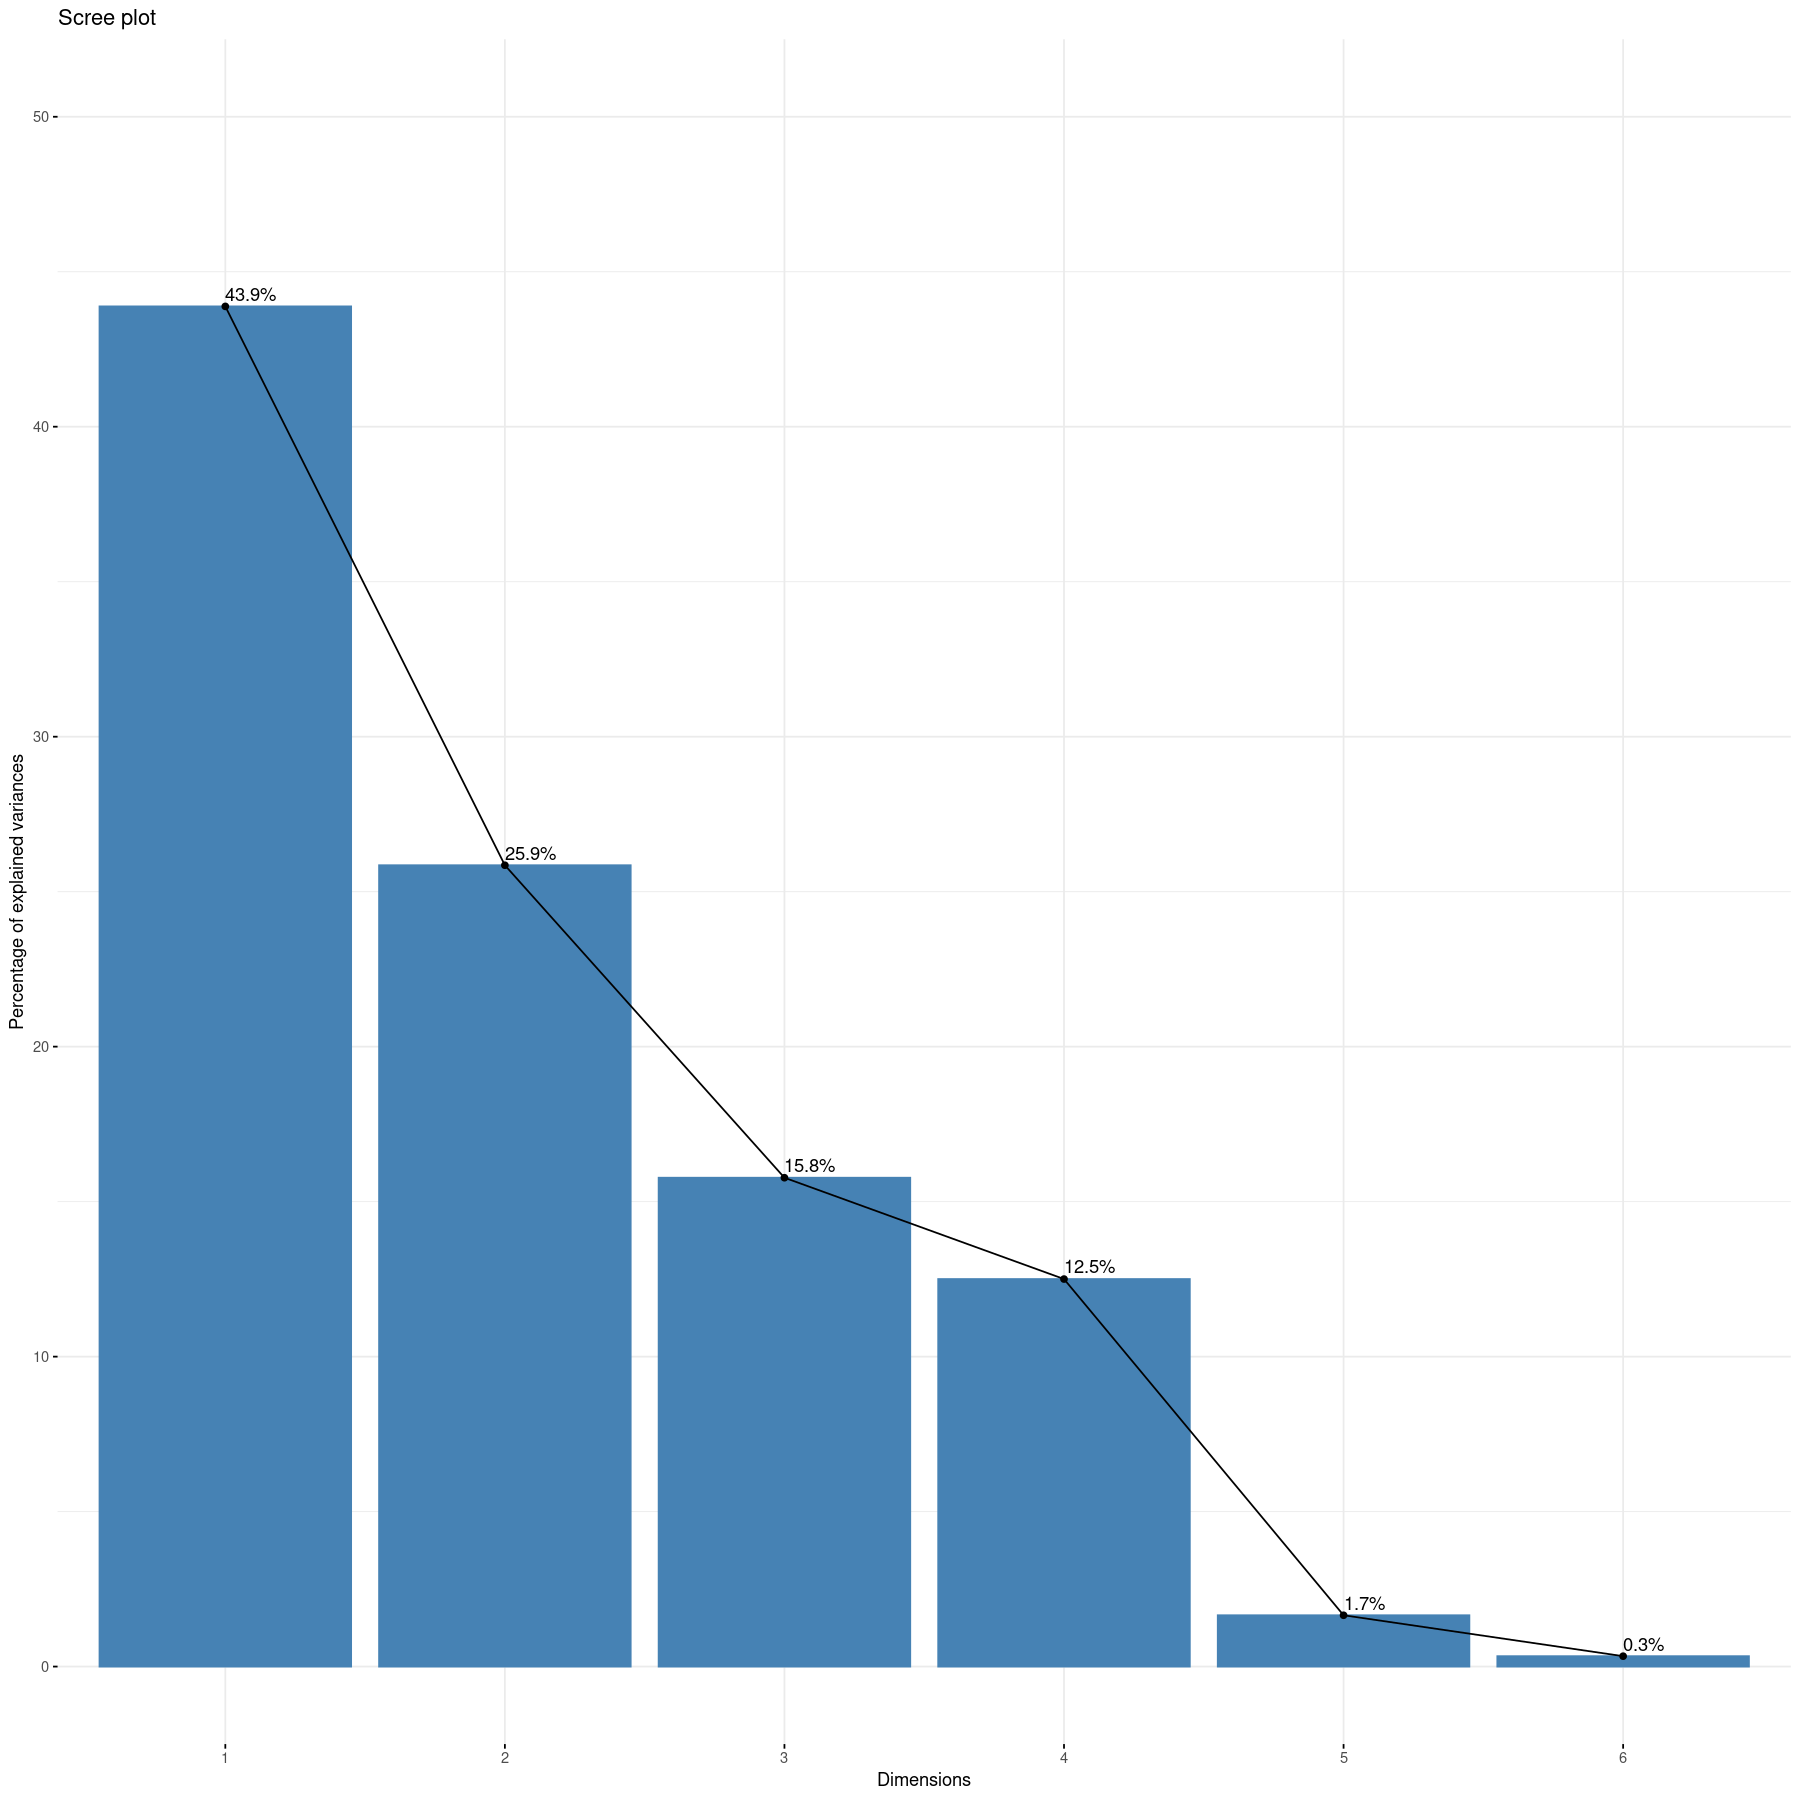

In [632]:
fviz_screeplot(pca_traits, addlabels = TRUE, ylim = c(0, 50))

In [633]:
# Extract loadings
pca_traits$loadings


Loadings:
           Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6
amax        0.607                       0.325  0.718
gs          0.233  0.610  0.505  0.107 -0.554       
wue         0.454 -0.335 -0.488 -0.141 -0.649       
pnue        0.287  0.534 -0.323 -0.553  0.312 -0.353
d13c        0.141 -0.422  0.598 -0.666              
narea_g_m2  0.518 -0.224  0.211  0.459  0.261 -0.598

               Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6
SS loadings     1.000  1.000  1.000  1.000  1.000  1.000
Proportion Var  0.167  0.167  0.167  0.167  0.167  0.167
Cumulative Var  0.167  0.333  0.500  0.667  0.833  1.000

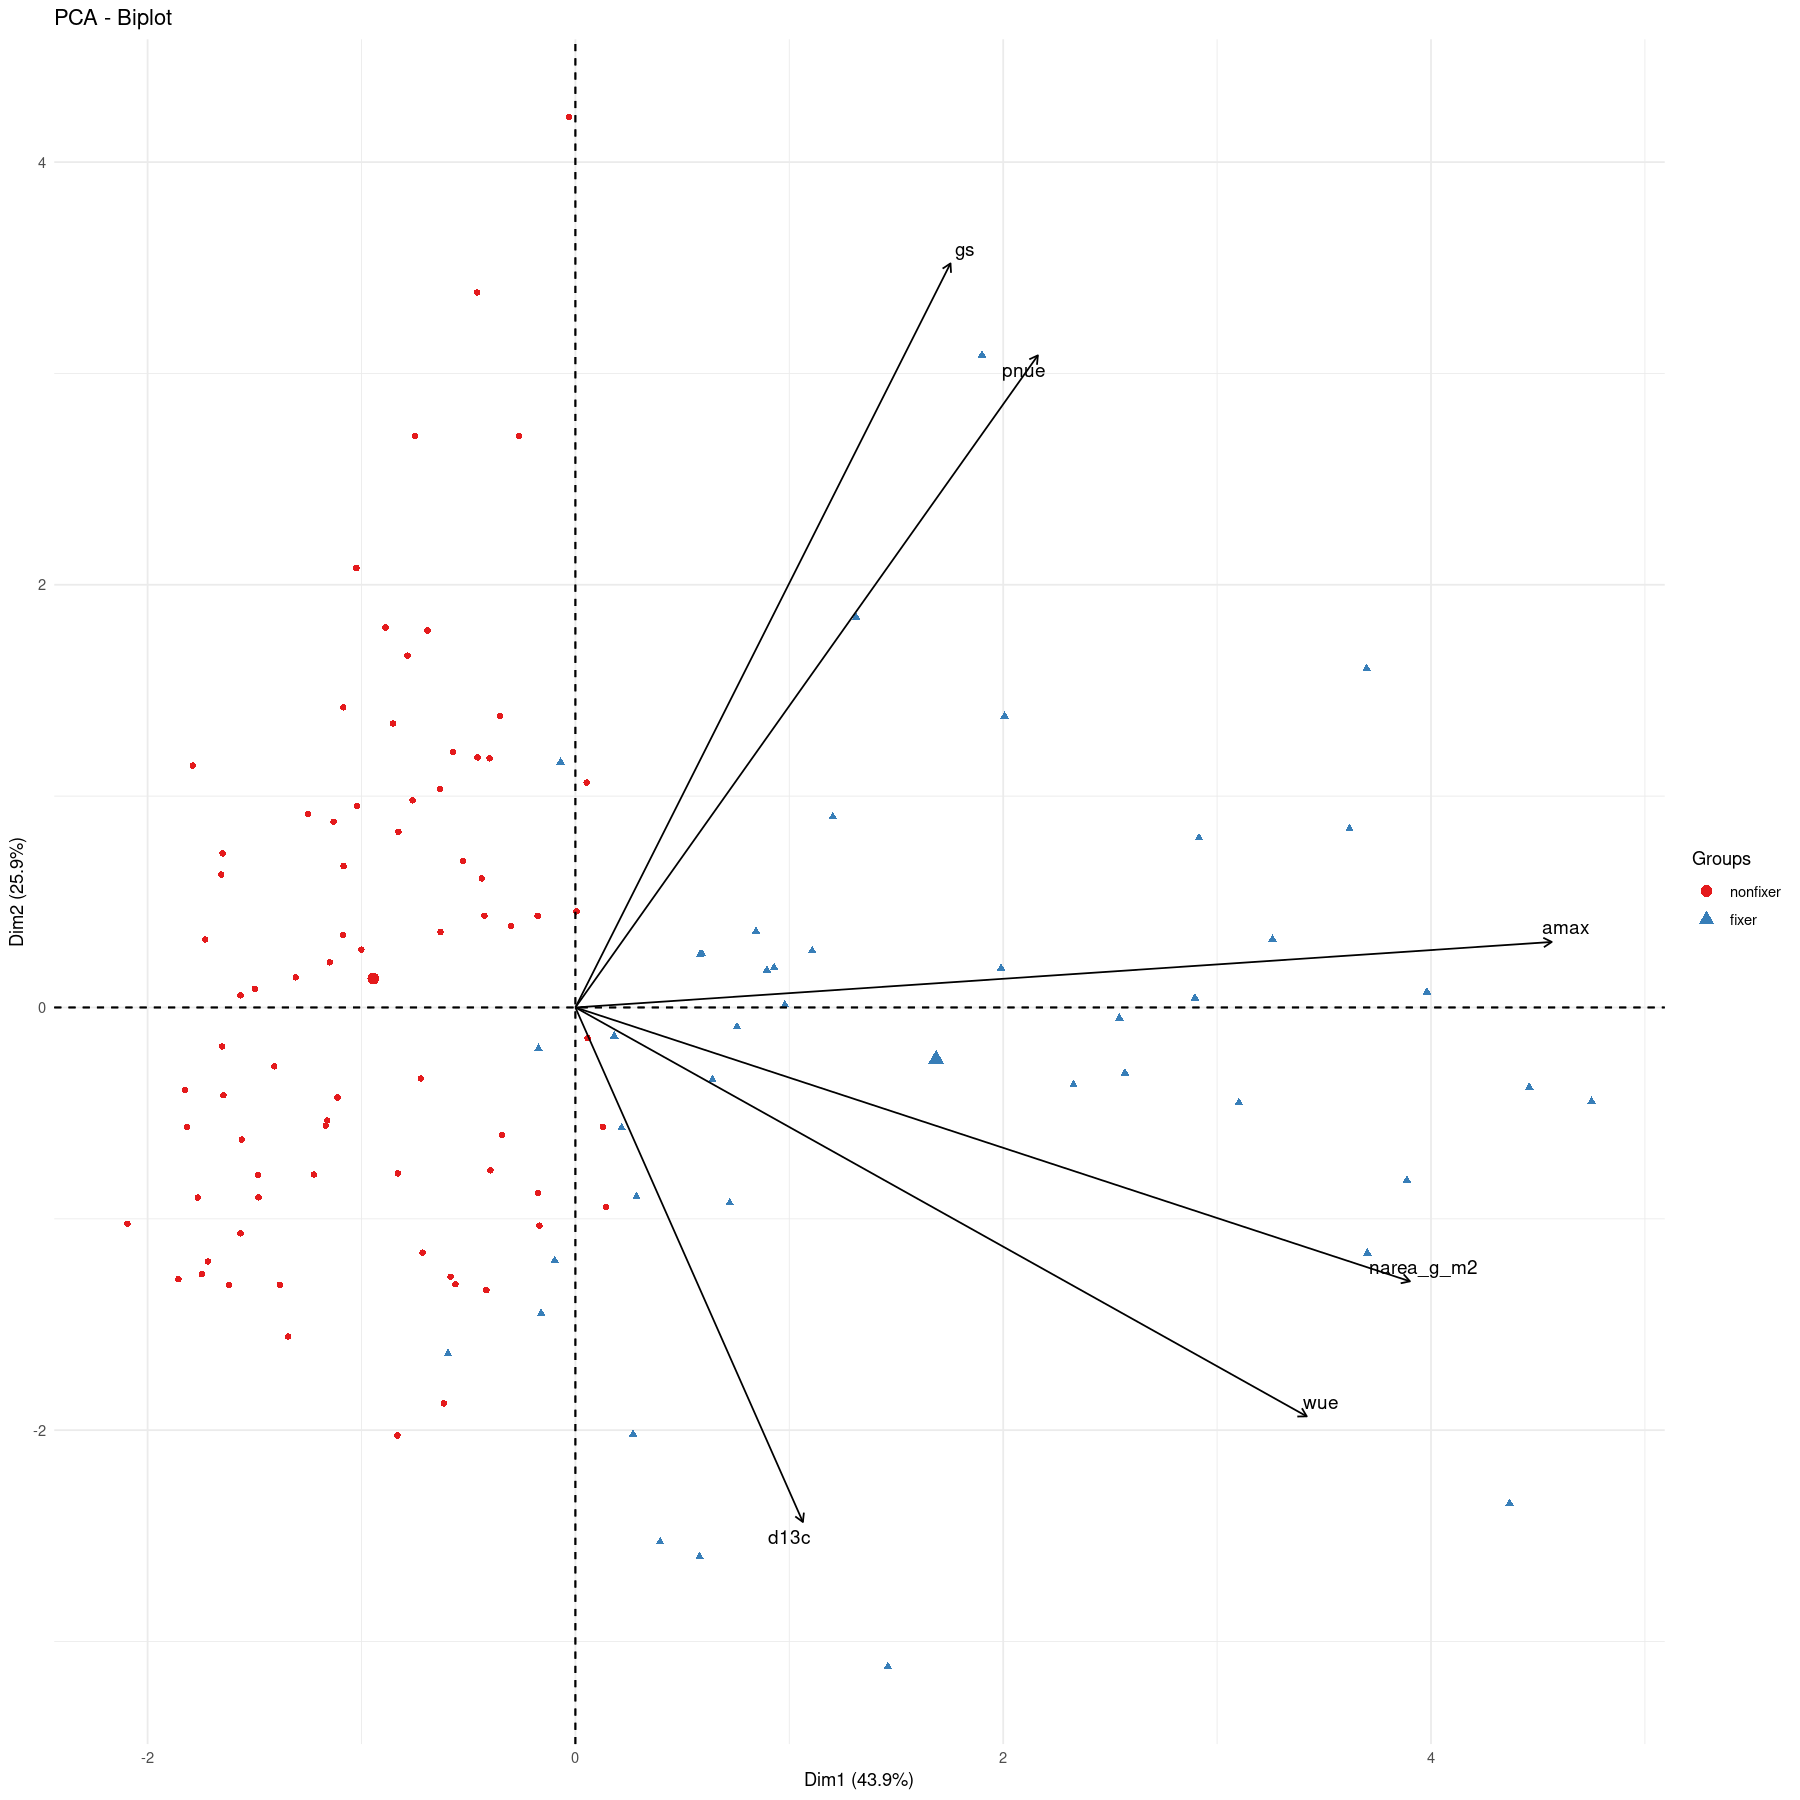

In [634]:
fviz_pca_biplot(pca_traits,axes = c(1, 2),

                # Add group
                habillage= data_traits_scaled$nfixer,

                # Set labels
                label ="var",

                # Set arrow color
                col.var = "black",

                # Repel overlapping labels
                repel = TRUE) +
  theme_minimal() + scale_color_brewer(palette="Set1")

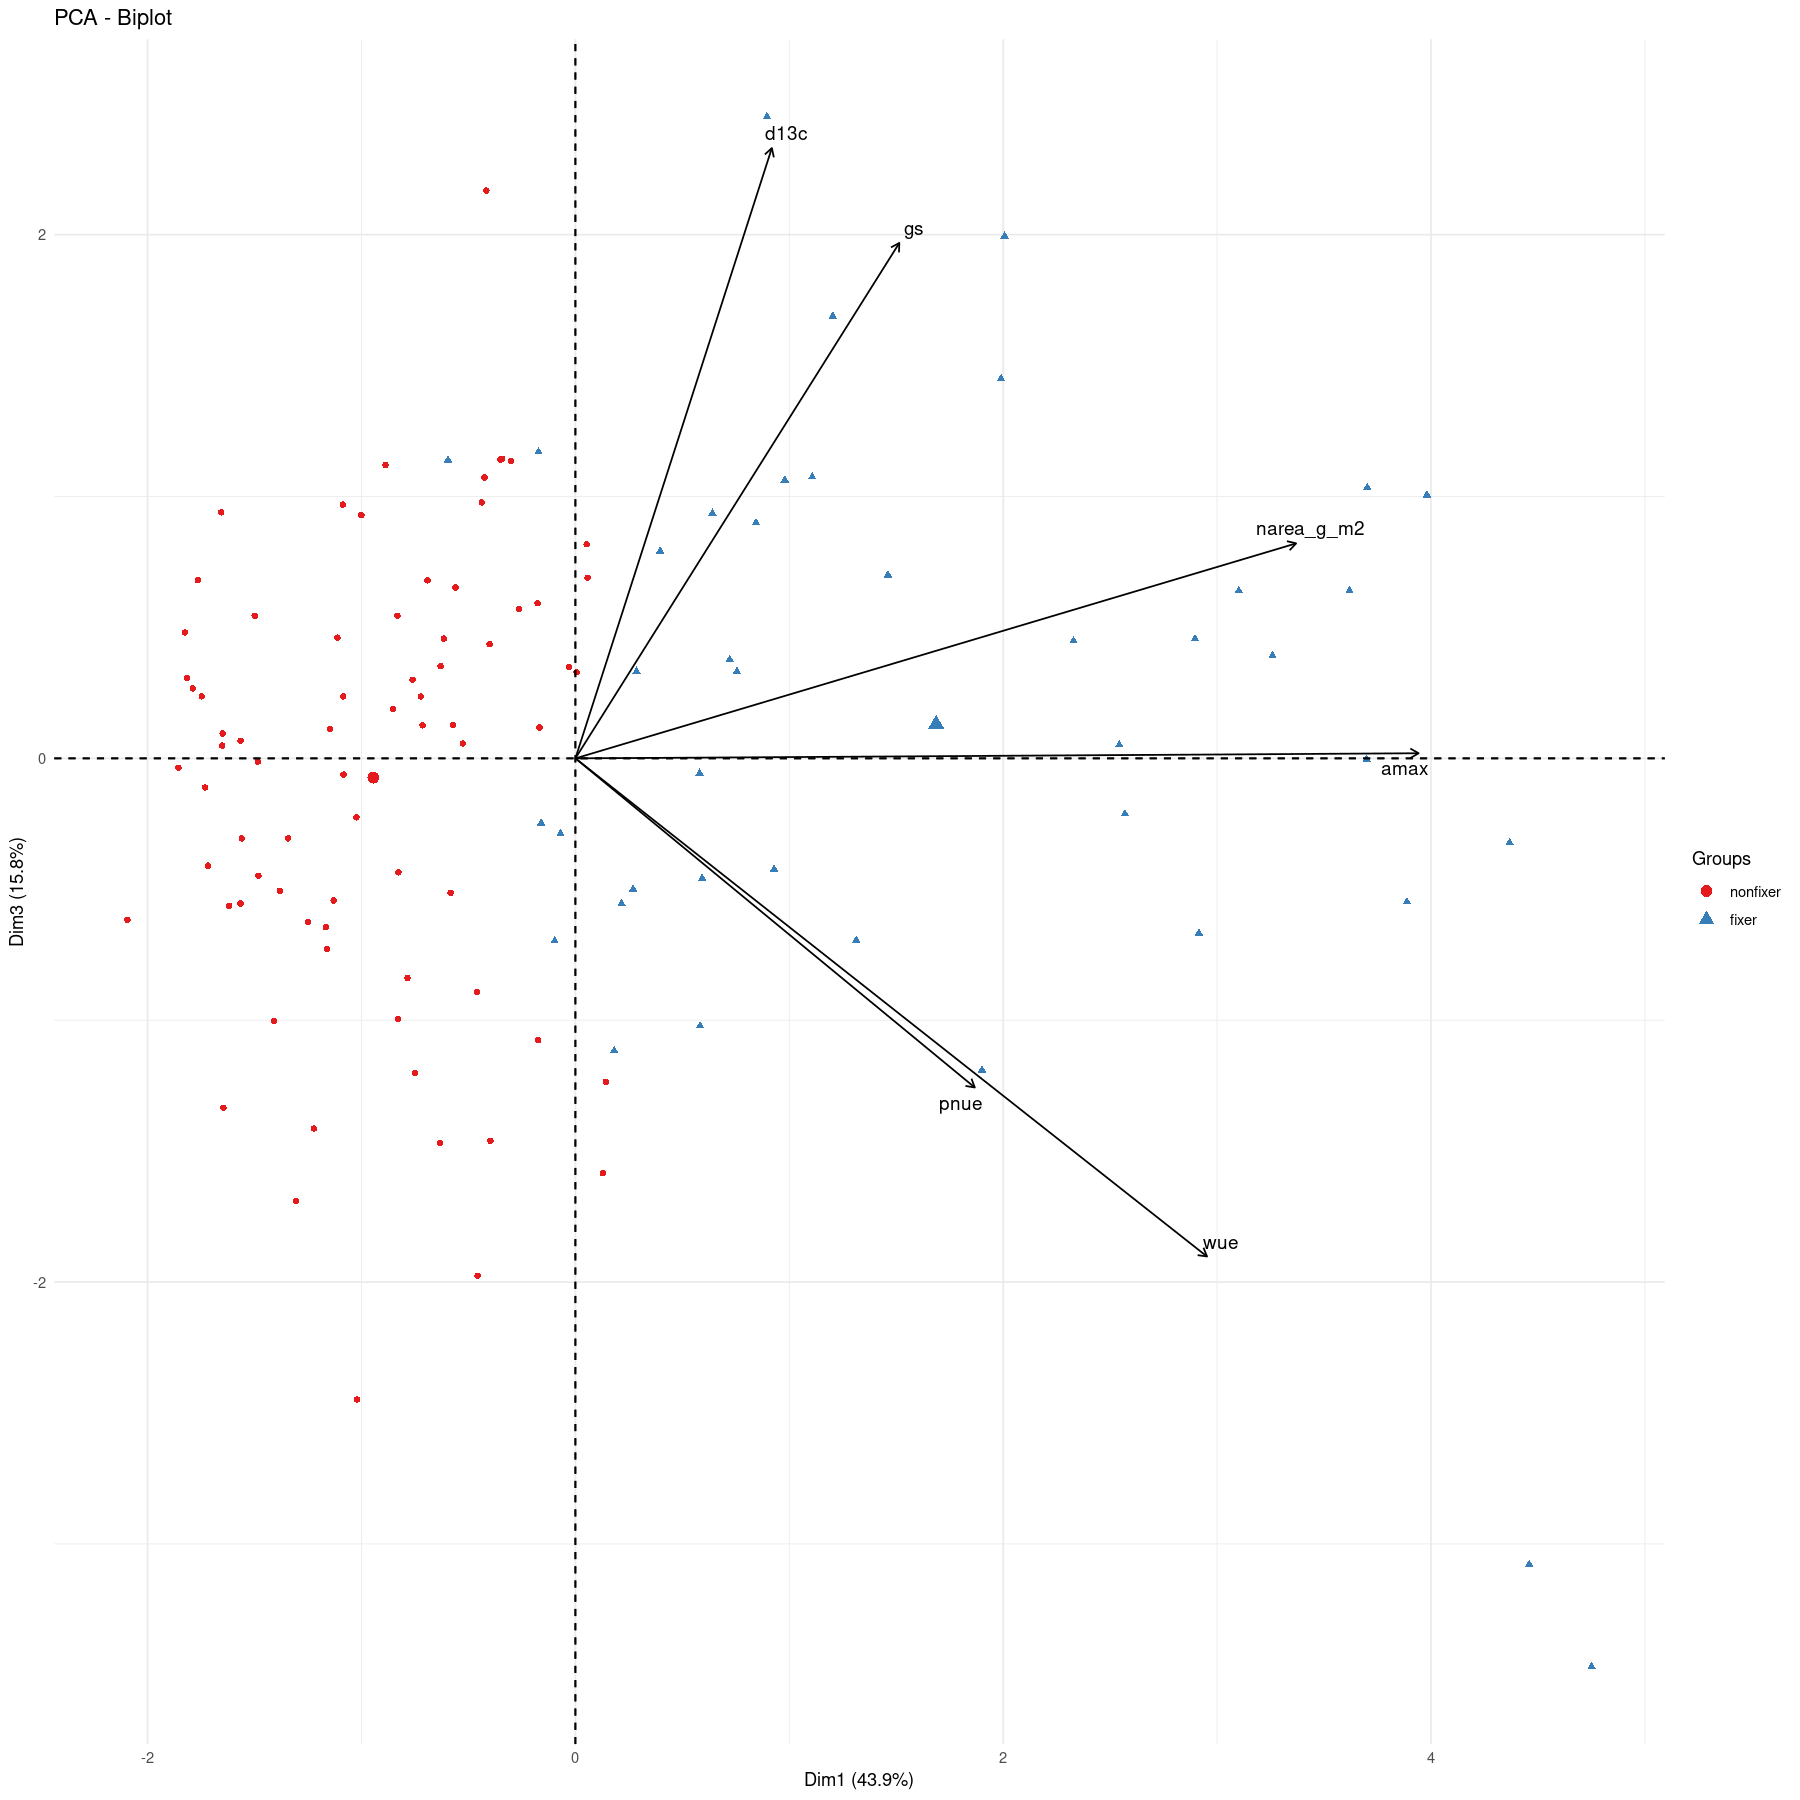

In [635]:
fviz_pca_biplot(pca_traits,axes = c(1, 3),

                # Add group
                habillage = data_traits_scaled$nfixer,

                # Set labels
                label ="var",

                # Set arrow color
                col.var = "black",

                # Repel overlapping labels
                repel = TRUE) +
  theme_minimal() + scale_color_brewer(palette="Set1")

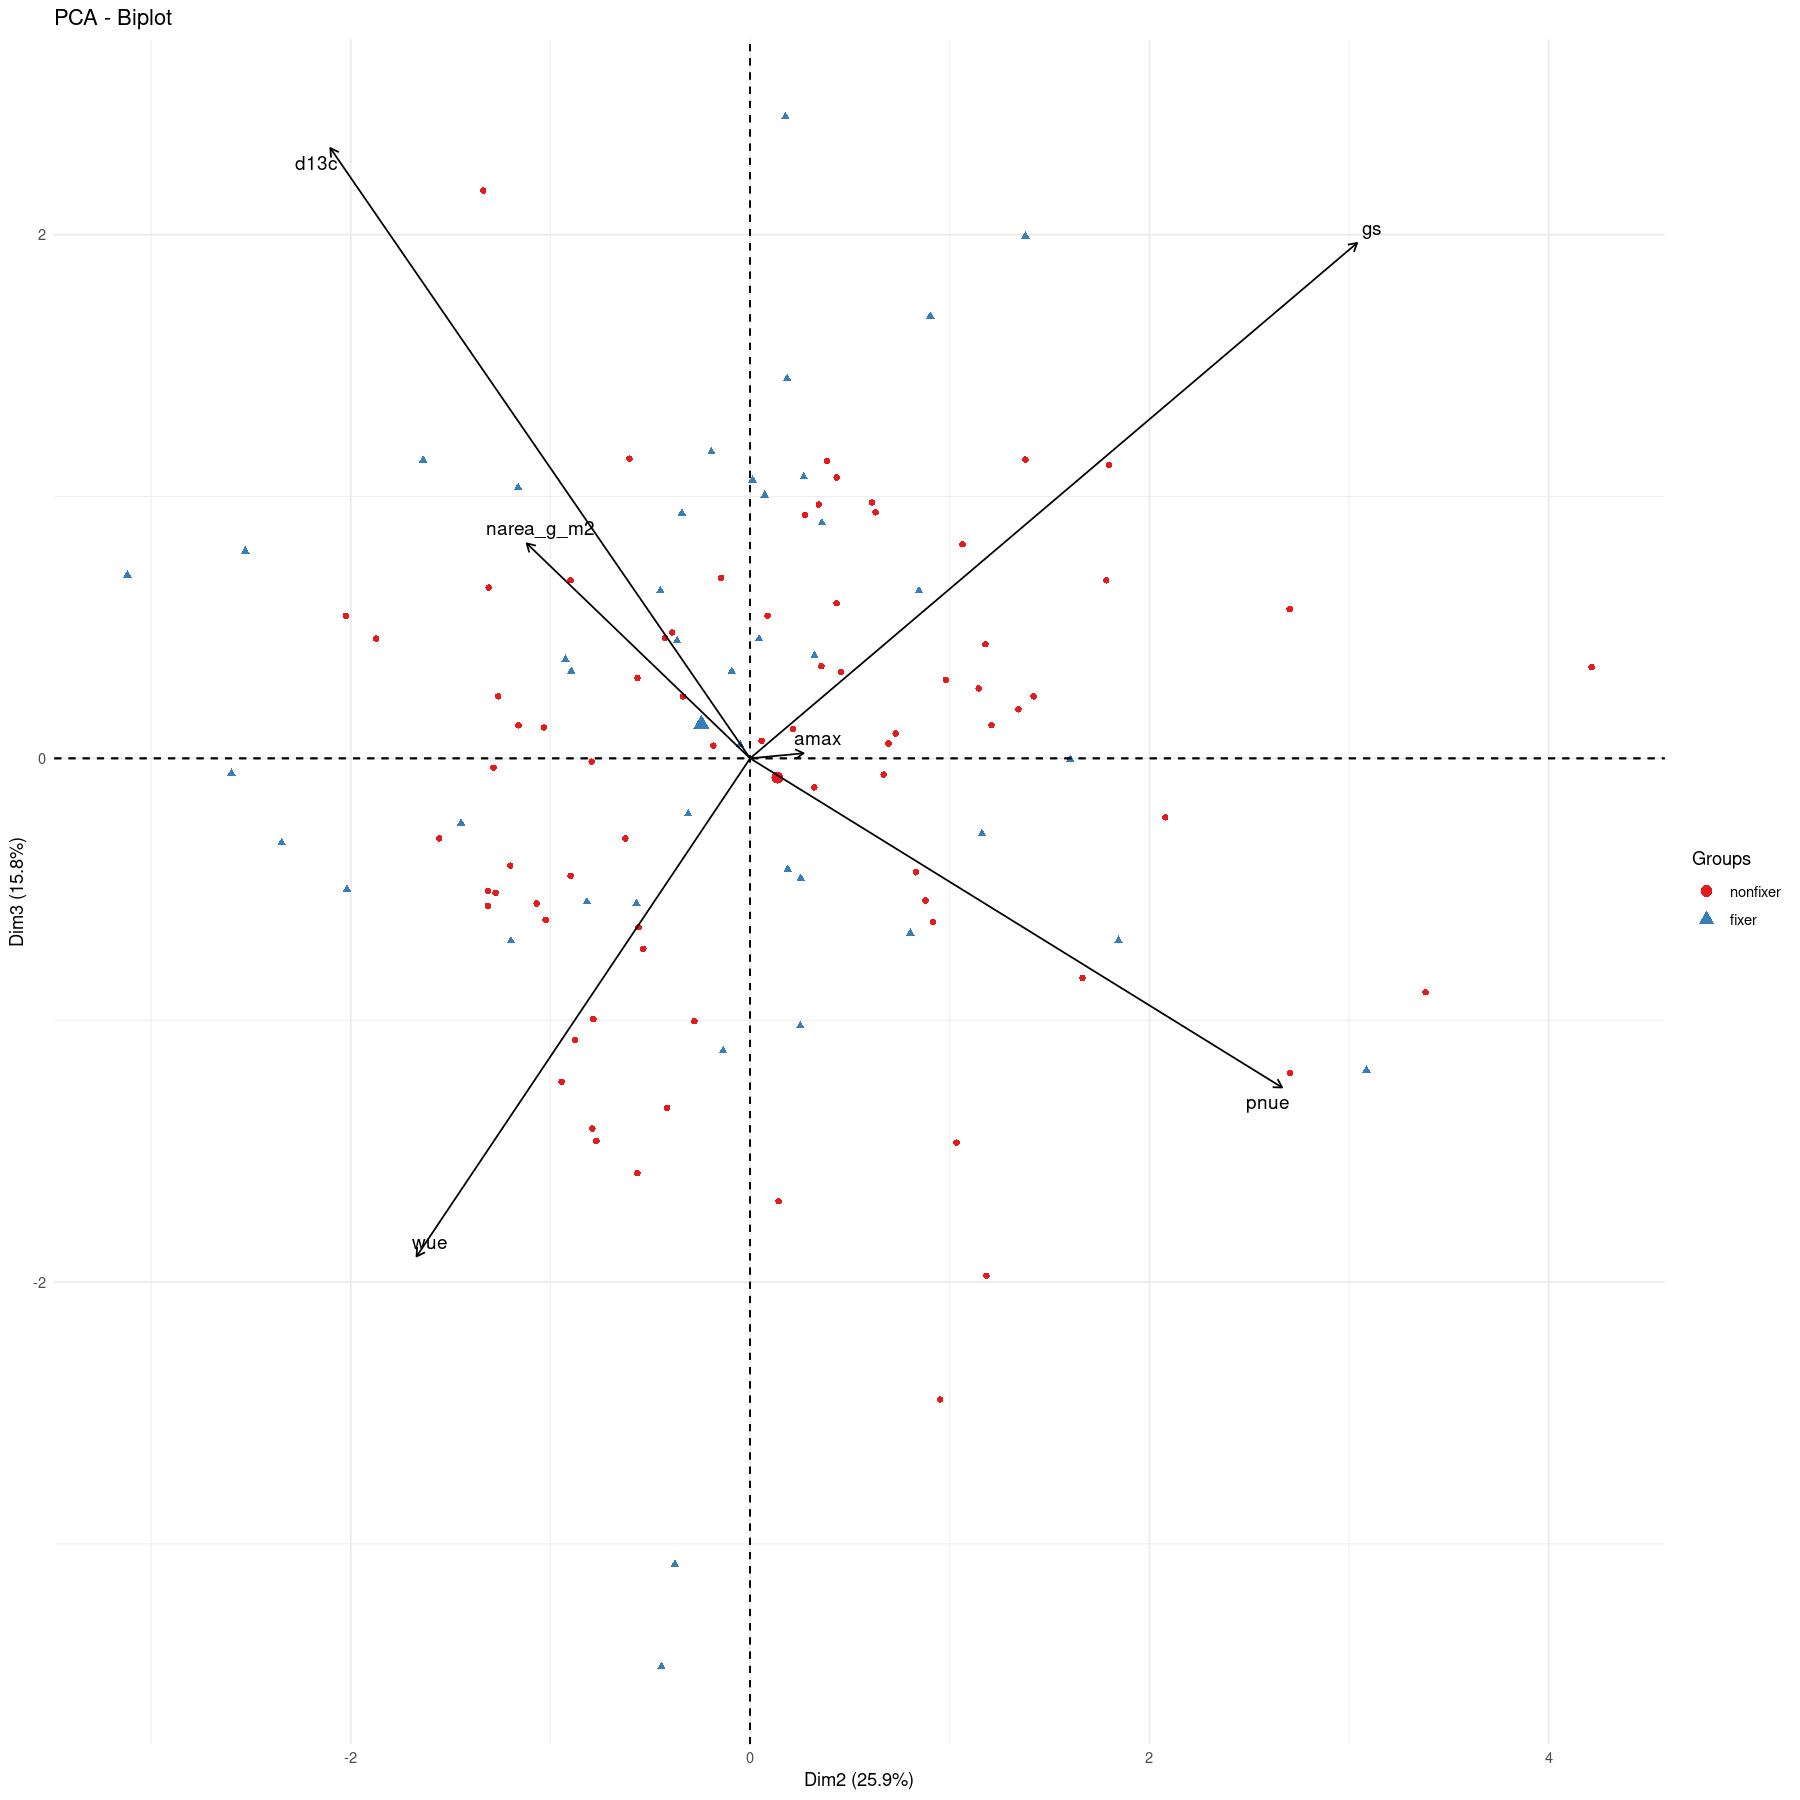

In [636]:
fviz_pca_biplot(pca_traits,axes = c(2, 3),

                # Add group
                habillage = data_traits_scaled$nfixer,

                # Set labels
                label ="var",

                # Set arrow color
                col.var = "black",

                # Repel overlapping labels
                repel = TRUE) +
  theme_minimal() + scale_color_brewer(palette="Set1")

## Biplots interpretation
[PCA interpretation](https://wilkelab.org/SDS375/slides/dimension-reduction-1.html#18)

+ The first 3 PCs explains 81% (47.9,19.4,15.8) of the variability in the data
+ PC1 separates fixers from non-fixers
+ All traits contribute positively to PC1 

+ PC1 represents the overall high photosynthetic capacity 
+ PC2 represents the difference between stomatal conductance and 
+ PC3 represents the difference between d13c and 

## Regression models 

$$response\sim treatment*fixer*PCn\ + initial\ height\ + random(1|specie)$$

In [637]:
pca_scores <- scores(pca_traits)


In [638]:
data_for_regression_pcs <-

    data_for_models %>%
        dplyr::select(-c(amax, gs,wue, narea_g_m2, pnue))


data_for_regression_pcs$pc1 <- pca_scores[,1]
data_for_regression_pcs$pc2 <- pca_scores[,2]
data_for_regression_pcs$pc3 <- pca_scores[,3]

In [561]:
#data_for_regression_scaled_traits <-
#    inner_join(data_performance, data_traits_scaled, , by = c("treatment","spcode", "nfixer"))


In [639]:
# add t-ratio
emm_options(contrast = list(infer = c(TRUE, TRUE)))

### Total biomass

In [640]:
model_pc_total_biomass <- lmer(total_biomass ~  treatment * nfixer*pc1  +
                                                treatment * nfixer*pc2  +
                                                treatment * nfixer*pc3  +
                            scale(init_height) +

                            (1|spcode),

                            # Control over different plant heights


                        data = data_for_regression_pcs)

### Relative Growth Rate

In [641]:
model_pc_rgr <- lmer(rgr ~  treatment * nfixer * pc1 +
                            treatment * nfixer * pc2 +
                            treatment * nfixer * pc3 +
                            scale(init_height) +

                            (1|spcode),

                            # Control over different plant heights


                        data = data_for_regression_pcs)

### Root to shoot ratio

In [642]:
model_pc_root_shoot <- lmer(root_shoot_ratio ~  treatment*nfixer * pc1 +
                                                treatment*nfixer * pc2  +
                                                treatment*nfixer * pc3 +

                            scale(init_height) +

                            (1|spcode),

                            # Control over different plant heights

                        data = data_for_regression_pcs)

## Model Assumptions

[1] "No variable specified inthe variables argument"


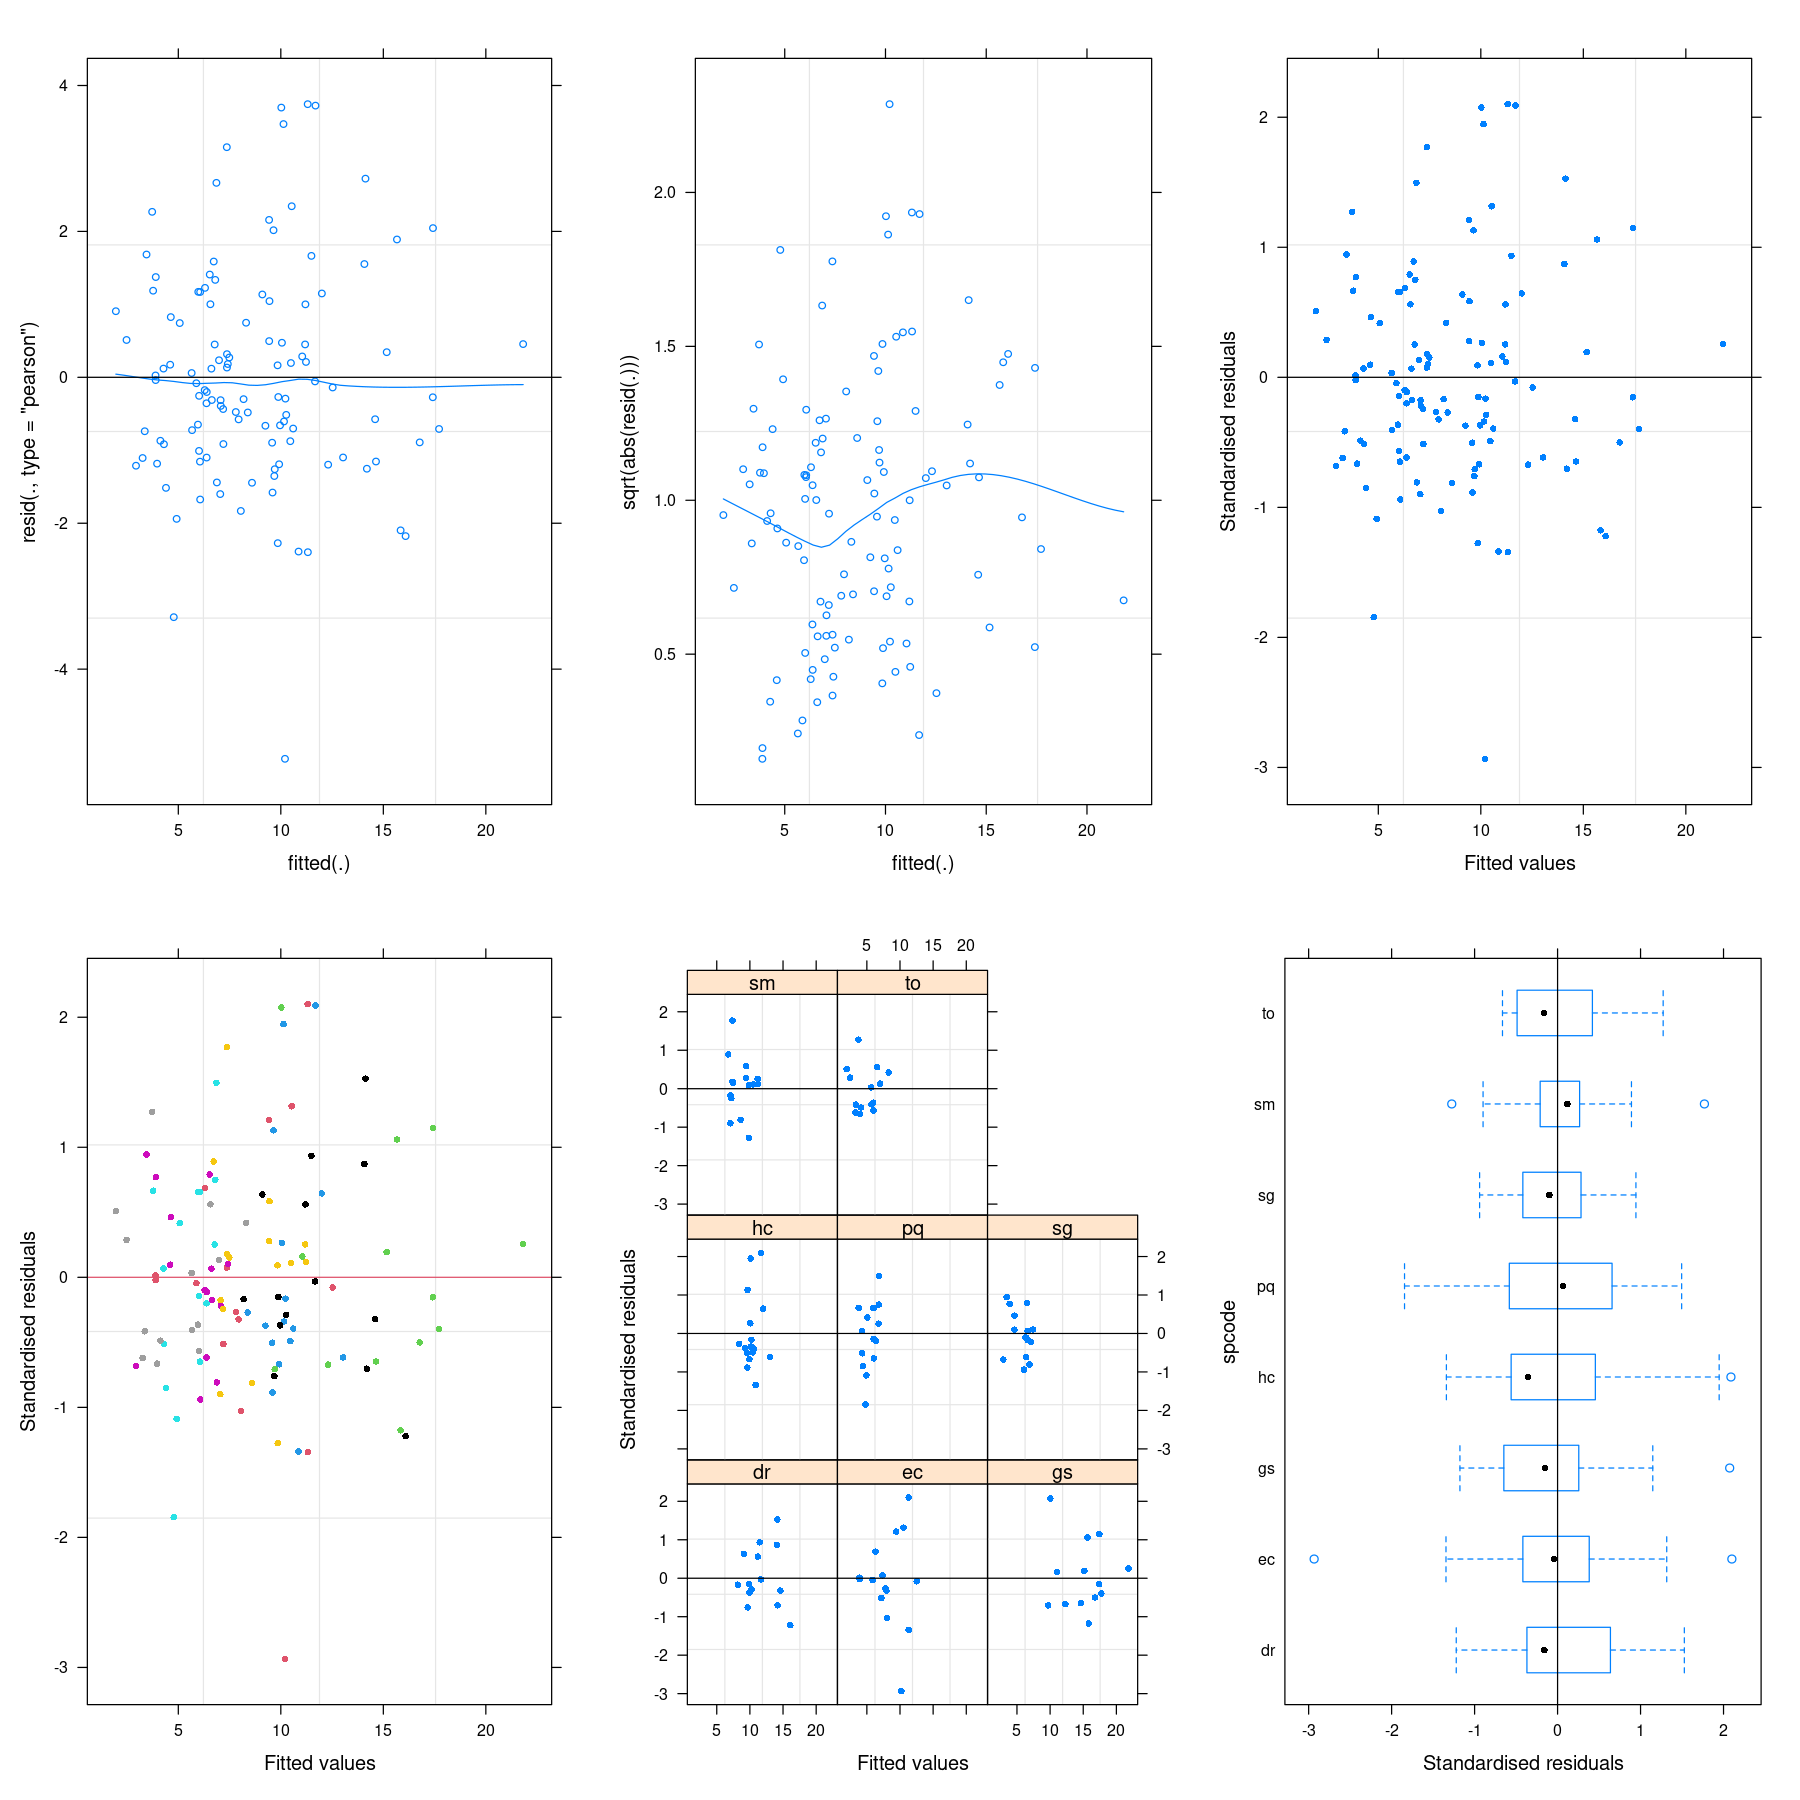

In [643]:
par(mfrow = c(3,3))
validation_plots(model_pc_total_biomass, data = data_for_models,group = "spcode")

[1] "No variable specified inthe variables argument"


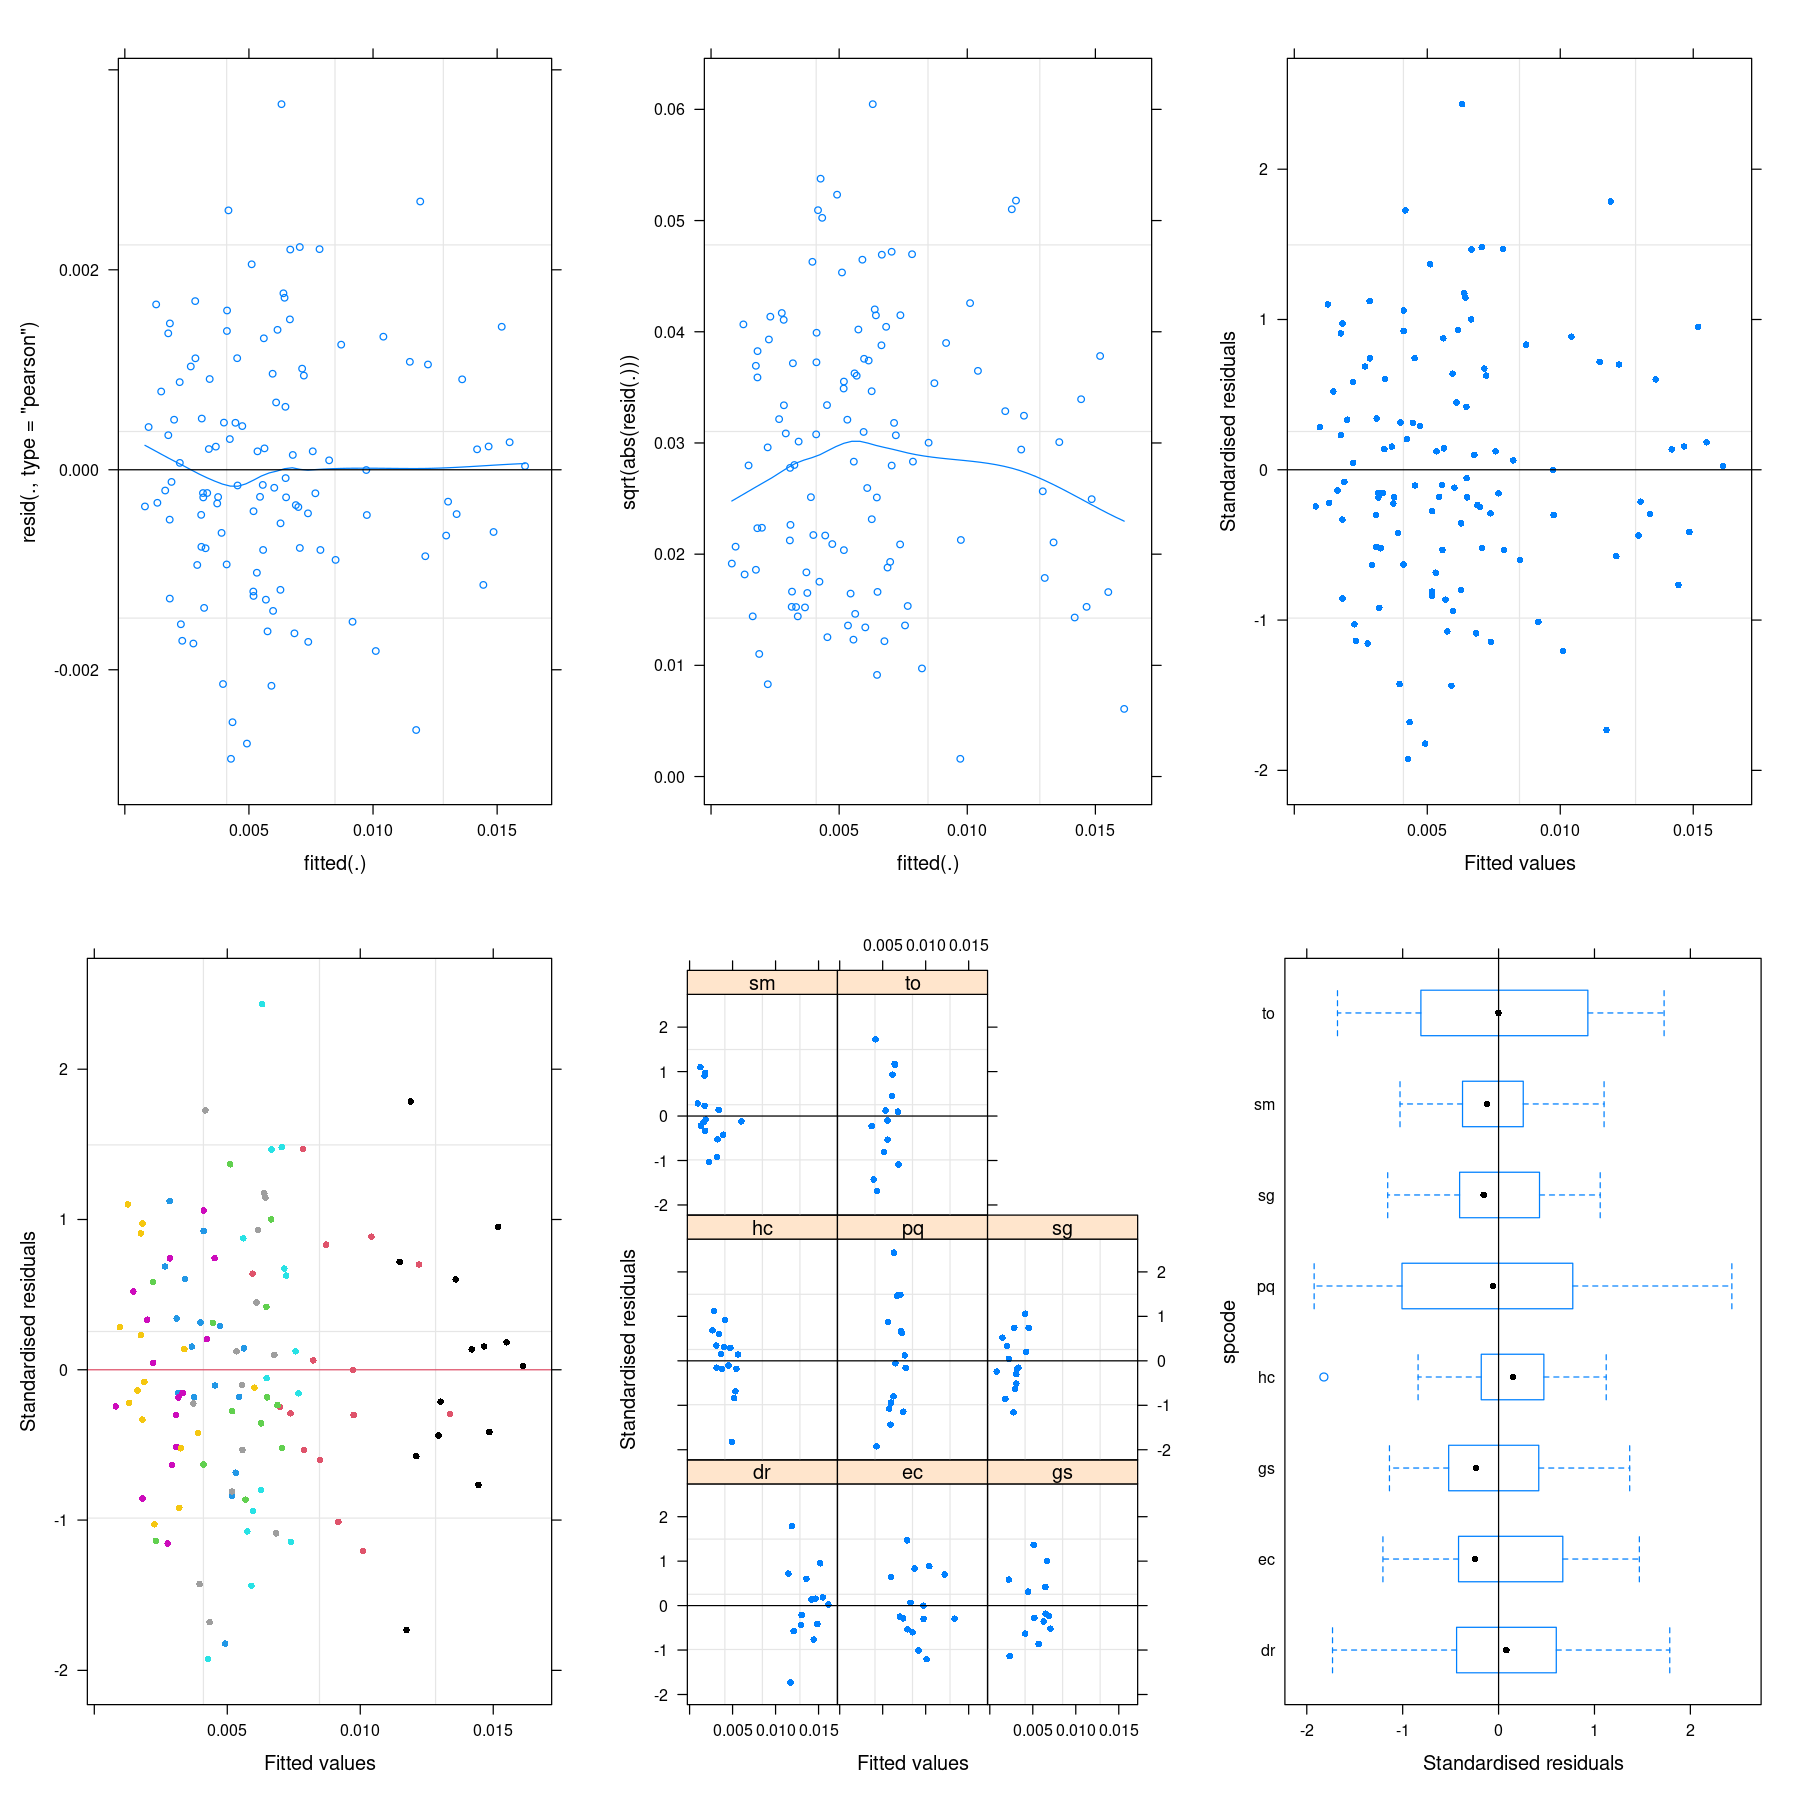

In [644]:
par(mfrow = c(3,3))
validation_plots(model_pc_rgr, data = data_for_models,group = "spcode")

[1] "No variable specified inthe variables argument"


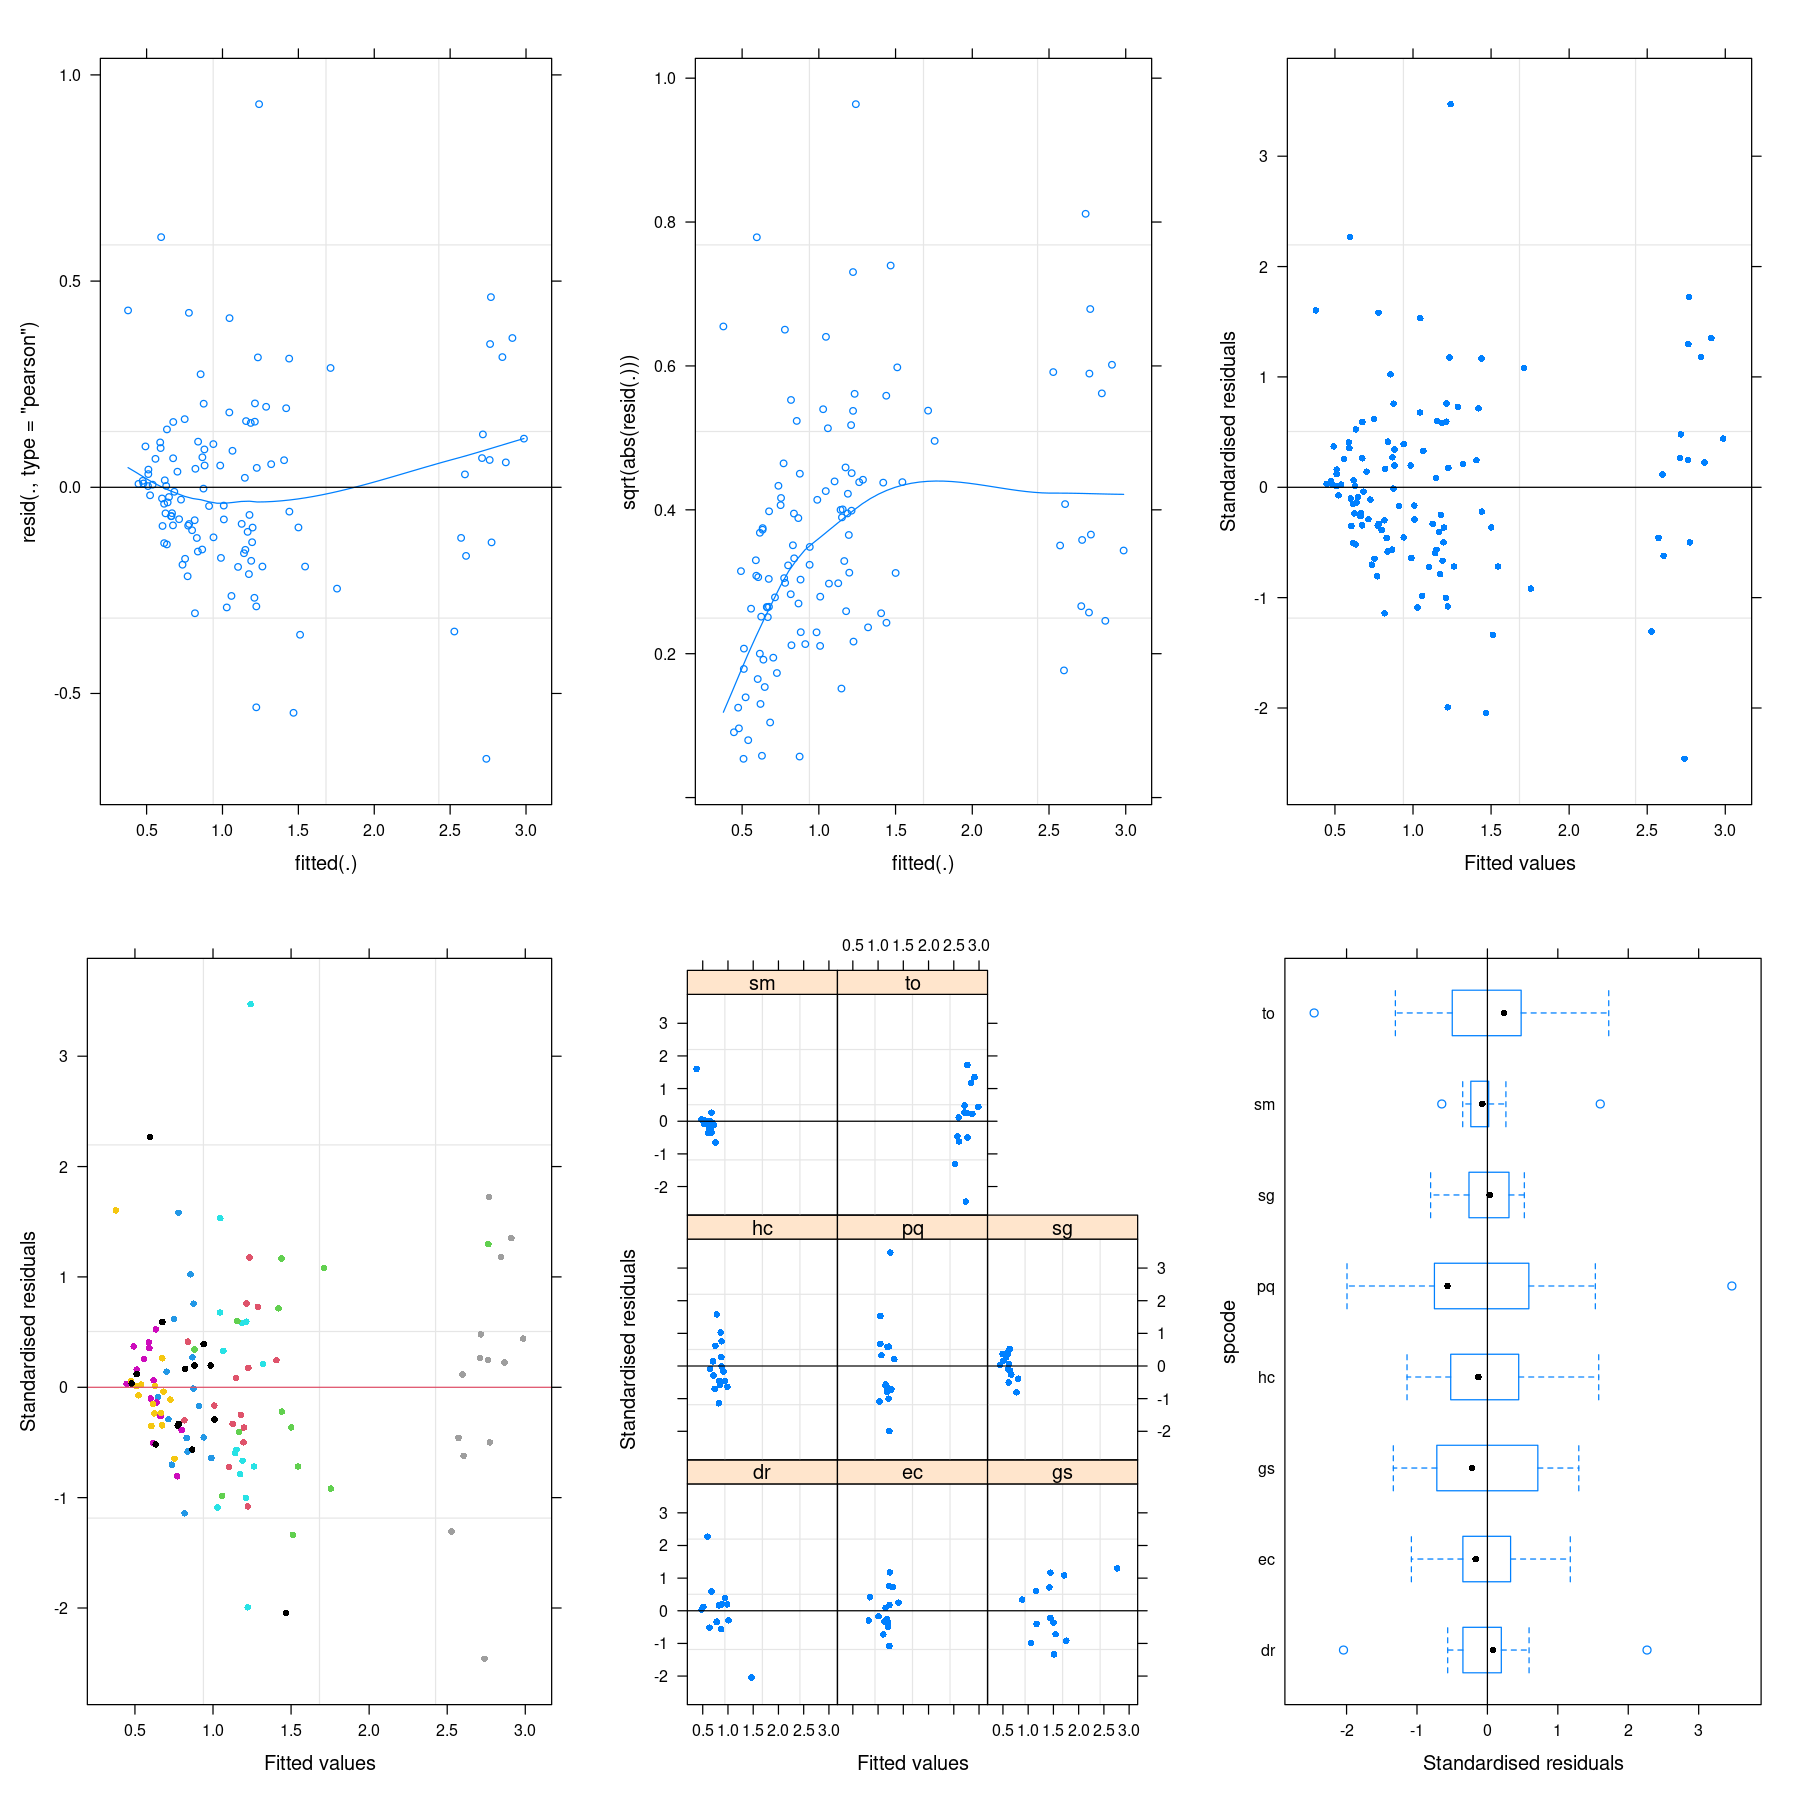

In [645]:
par(mfrow = c(3,3))
validation_plots(model_pc_root_shoot, data = data_for_models,group = "spcode")

## Model inference

In [646]:
## r2 models

r2(model_pc_total_biomass) %>%
    kable()



| R2_conditional| R2_marginal|optional |
|--------------:|-----------:|:--------|
|       0.830969|   0.5967031|FALSE    |

In [647]:
r2(model_pc_rgr) %>%
    kable()



| R2_conditional| R2_marginal|optional |
|--------------:|-----------:|:--------|
|       0.915836|    0.482896|FALSE    |

In [648]:
r2(model_pc_root_shoot) %>%
    kable()



| R2_conditional| R2_marginal|optional |
|--------------:|-----------:|:--------|
|      0.8965455|   0.0815889|FALSE    |

## Anova tables

### Total Biomass

In [649]:
Anova(model_pc_total_biomass, type = "III", test.statistic = c("F"))

,F,Df,Df.res,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),31.831835915,1,16.16401,3.537215e-05
treatment,1.347748100,3,79.70586,2.648808e-01
nfixer,0.043727237,1,12.17661,8.378194e-01
pc1,2.126549485,1,82.60169,1.485582e-01
pc2,1.010666273,1,83.70083,3.176408e-01
pc3,5.568211352,1,83.29968,2.062831e-02
scale(init_height),7.737431924,1,33.07959,8.862582e-03
treatment:nfixer,5.978536935,3,81.63136,9.792848e-04
treatment:pc1,3.598212257,3,79.53925,1.705766e-02


#### Amax

In [650]:
emtrends(model_pc_total_biomass,
        pairwise ~ nfixer*treatment,
        var = "pc1")$contrast %>%
        kable()




|contrast                                                   |   estimate|        SE|       df|   lower.CL| upper.CL|    t.ratio|   p.value|
|:----------------------------------------------------------|----------:|---------:|--------:|----------:|--------:|----------:|---------:|
|nonfixer no_additions - fixer no_additions                 |  1.2401450| 1.0401000| 83.90357| -1.9932610| 4.473551|  1.1923325| 0.9319794|
|nonfixer no_additions - nonfixer plus_nutrients            |  3.9280127| 1.2285781| 80.25072|  0.1042642| 7.751761|  3.1972023| 0.0397433|
|nonfixer no_additions - fixer plus_nutrients               |  3.5238145| 1.3783576| 83.30285| -0.7619321| 7.809561|  2.5565314| 0.1870762|
|nonfixer no_additions - nonfixer plus_water                |  1.9957936| 1.2092373| 79.08162| -1.7692356| 5.760823|  1.6504565| 0.7183317|
|nonfixer no_additions - fixer plus_water                   |  2.8739802| 1.2711771| 64.48477| -1.1080845| 6.856045|  2.2608810| 0.3308842|
|nonfixer no_addit

#### gs

In [651]:
emtrends(model_pc_total_biomass,
        pairwise ~ nfixer*treatment,
        var = "pc2")$contrast %>%
        kable()



|contrast                                                   |   estimate|        SE|       df|  lower.CL|  upper.CL|    t.ratio|   p.value|
|:----------------------------------------------------------|----------:|---------:|--------:|---------:|---------:|----------:|---------:|
|nonfixer no_additions - fixer no_additions                 | -0.0572311| 0.9270310| 82.40388| -2.940465| 2.8260029| -0.0617360| 1.0000000|
|nonfixer no_additions - nonfixer plus_nutrients            | -0.6810183| 0.8978625| 81.71038| -3.474145| 2.1121084| -0.7584885| 0.9947052|
|nonfixer no_additions - fixer plus_nutrients               | -0.8444131| 1.2028510| 83.97534| -4.583690| 2.8948633| -0.7020097| 0.9967284|
|nonfixer no_additions - nonfixer plus_water                | -0.7718193| 1.0432604| 82.93638| -4.016010| 2.4723712| -0.7398146| 0.9954632|
|nonfixer no_additions - fixer plus_water                   | -1.4811604| 1.0951234| 83.76094| -4.885767| 1.9234464| -1.3525055| 0.8755669|
|nonfixer no_addit

#### d13c

In [652]:
emtrends(model_pc_total_biomass,
        pairwise ~ nfixer*treatment,
        var = "pc3")$contrast %>%
        kable()



|contrast                                                   |   estimate|        SE|       df|    lower.CL|   upper.CL|    t.ratio|   p.value|
|:----------------------------------------------------------|----------:|---------:|--------:|-----------:|----------:|----------:|---------:|
|nonfixer no_additions - fixer no_additions                 |  0.7974327| 0.8894546| 82.95894|  -1.9684540|  3.5633193|  0.8965411| 0.9856117|
|nonfixer no_additions - nonfixer plus_nutrients            | -0.1615301| 0.8654492| 79.94602|  -2.8553715|  2.5323112| -0.1866431| 0.9999996|
|nonfixer no_additions - fixer plus_nutrients               | -5.4652303| 2.1798715| 81.47268| -12.2470261|  1.3165655| -2.5071342| 0.2073139|
|nonfixer no_additions - nonfixer plus_water                | -0.1212554| 1.1769960| 80.14748|  -3.7845882|  3.5420774| -0.1030211| 1.0000000|
|nonfixer no_additions - fixer plus_water                   | -1.2423171| 1.3396208| 83.12441|  -5.4078472|  2.9232129| -0.9273648| 0.982509

#### PNUE

In [653]:
emtrends(model_pc_total_biomass,
        pairwise ~ pnue*treatment,
        var = "p")$contrast %>%
        kable()

ERROR: Error in emtrends(model_pc_total_biomass, pairwise ~ pnue * treatment, : Variable 'pnue' is not in the dataset


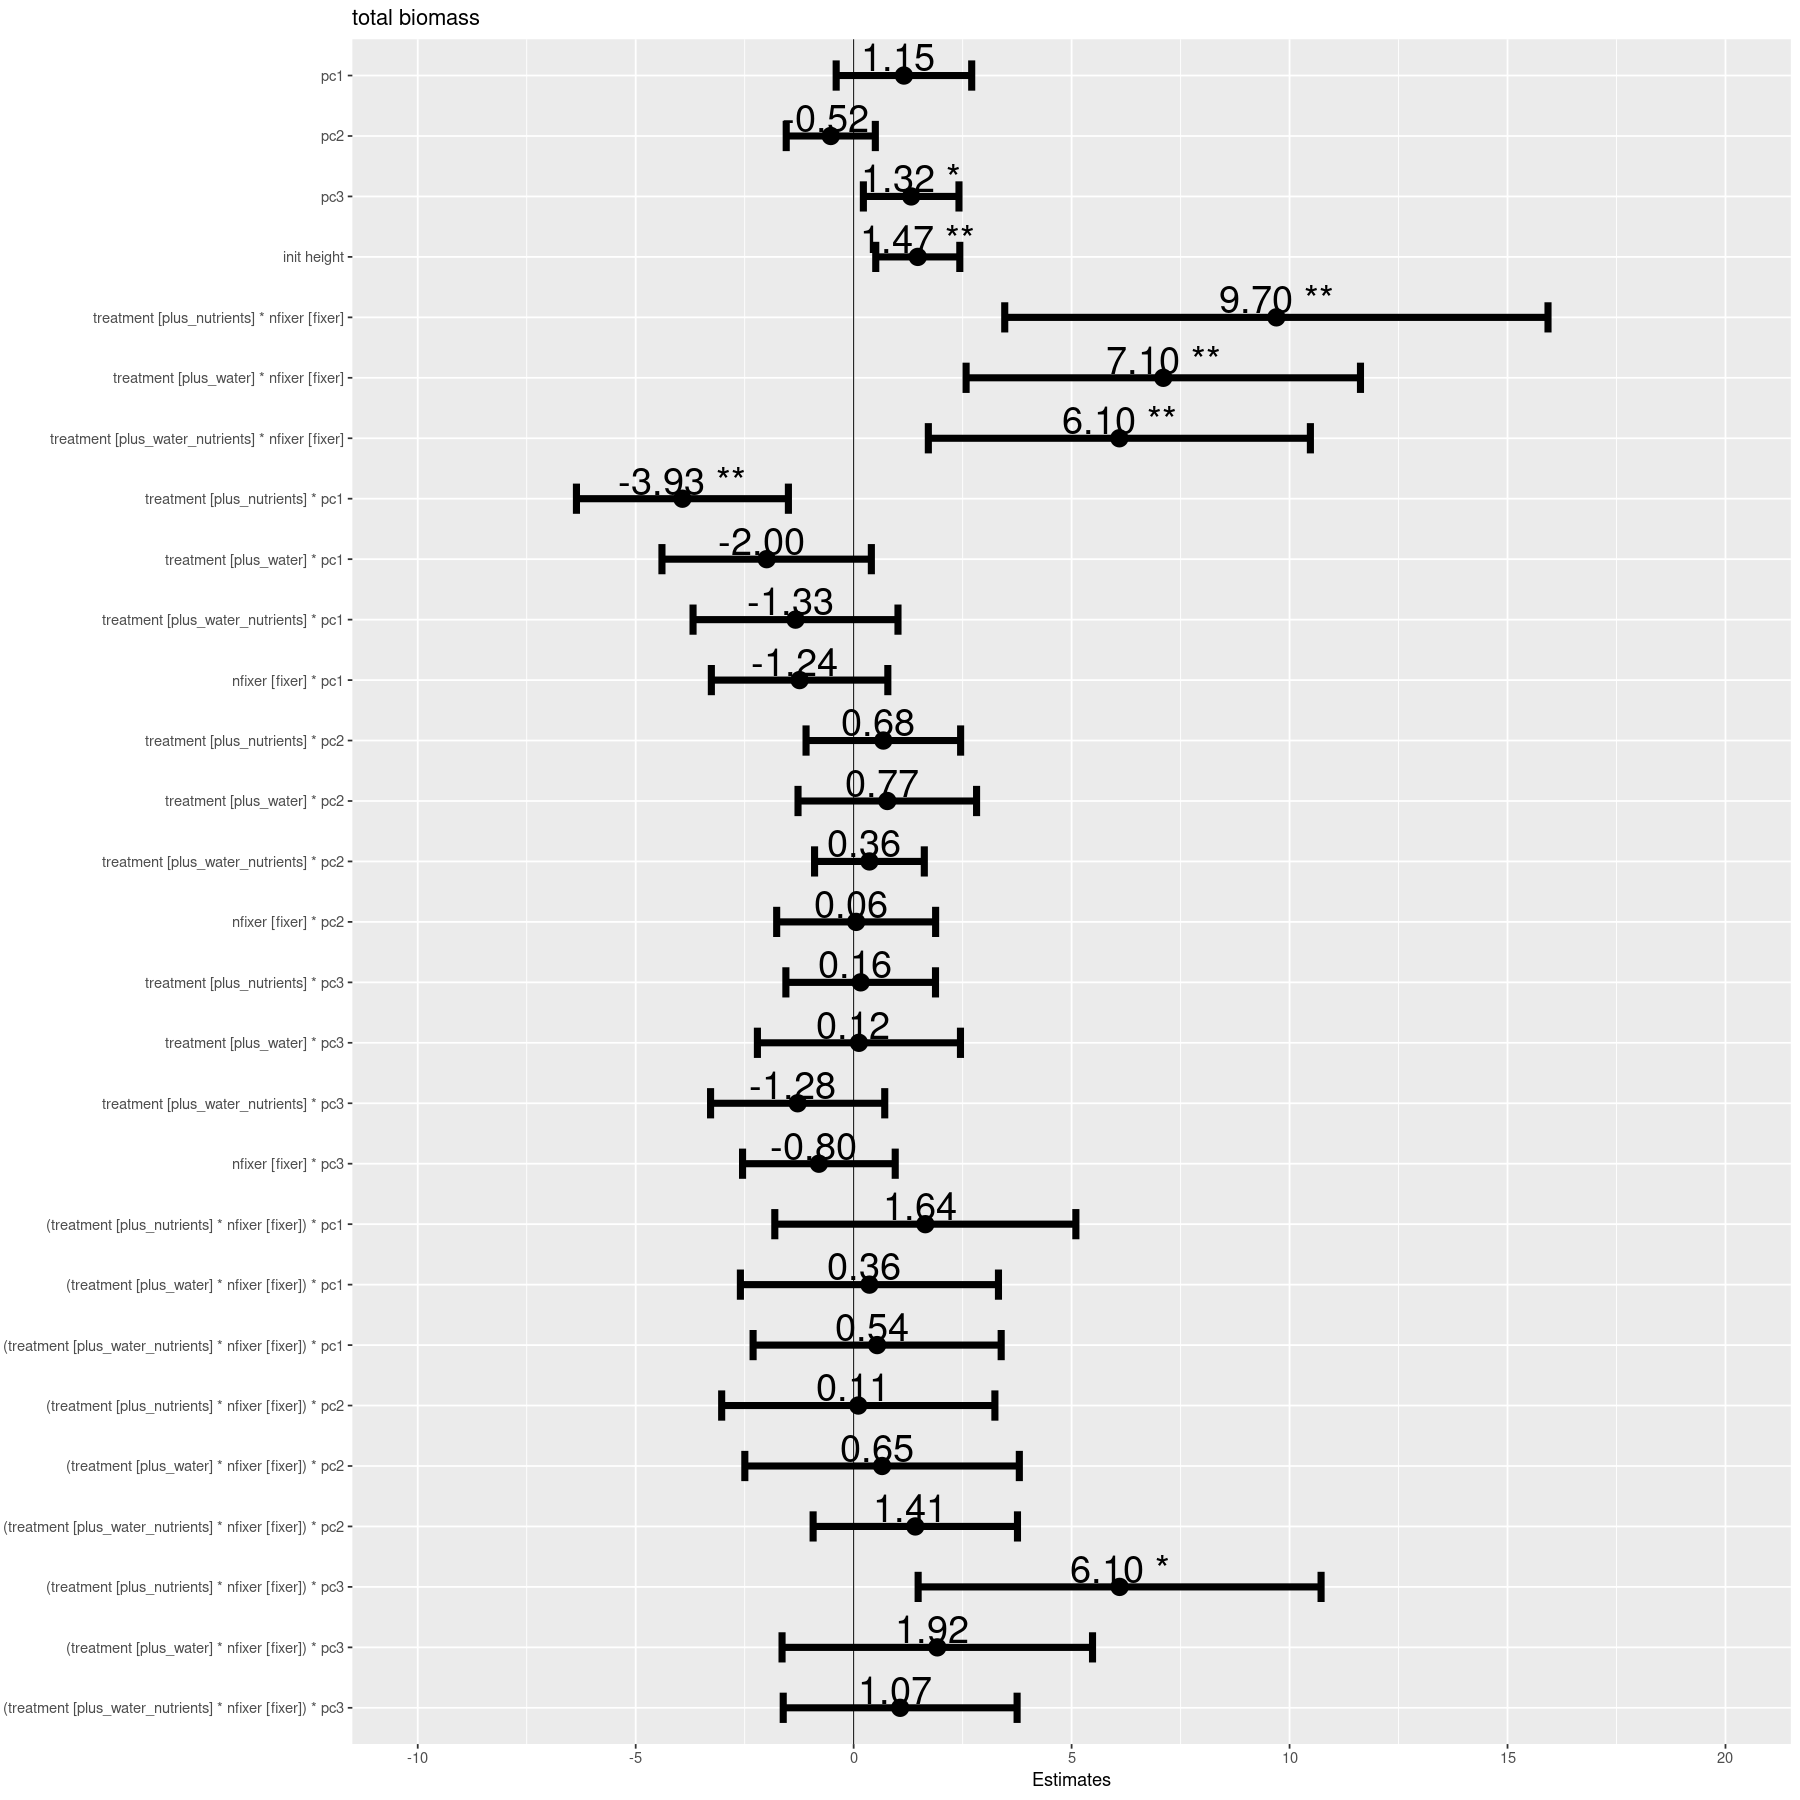

In [654]:
plot_model(model_pc_total_biomass, show.values = TRUE,

                        rm.terms = c("treatmentplus_nutrients","treatmentplus_water",
                                    "treatmentplus_water_nutrients",
                                    "amax", "gs", "d13c", "pnue", "init_height",
                                    "nfixerfixer", "amax:nfixerfixer",
                                    "gs:nfixerfixer", "d13c:nfixerfixer",
                                    "pnue:nfixerfixer"
                                    ),
                        colors = "black",
                        value.offset = .3,
                        value.size = 8,
                        dot.size = 4.5,
                        line.size = 2,
                        vline.color = "black",
                        width = 0.5,
                        show.p = TRUE,
                        )

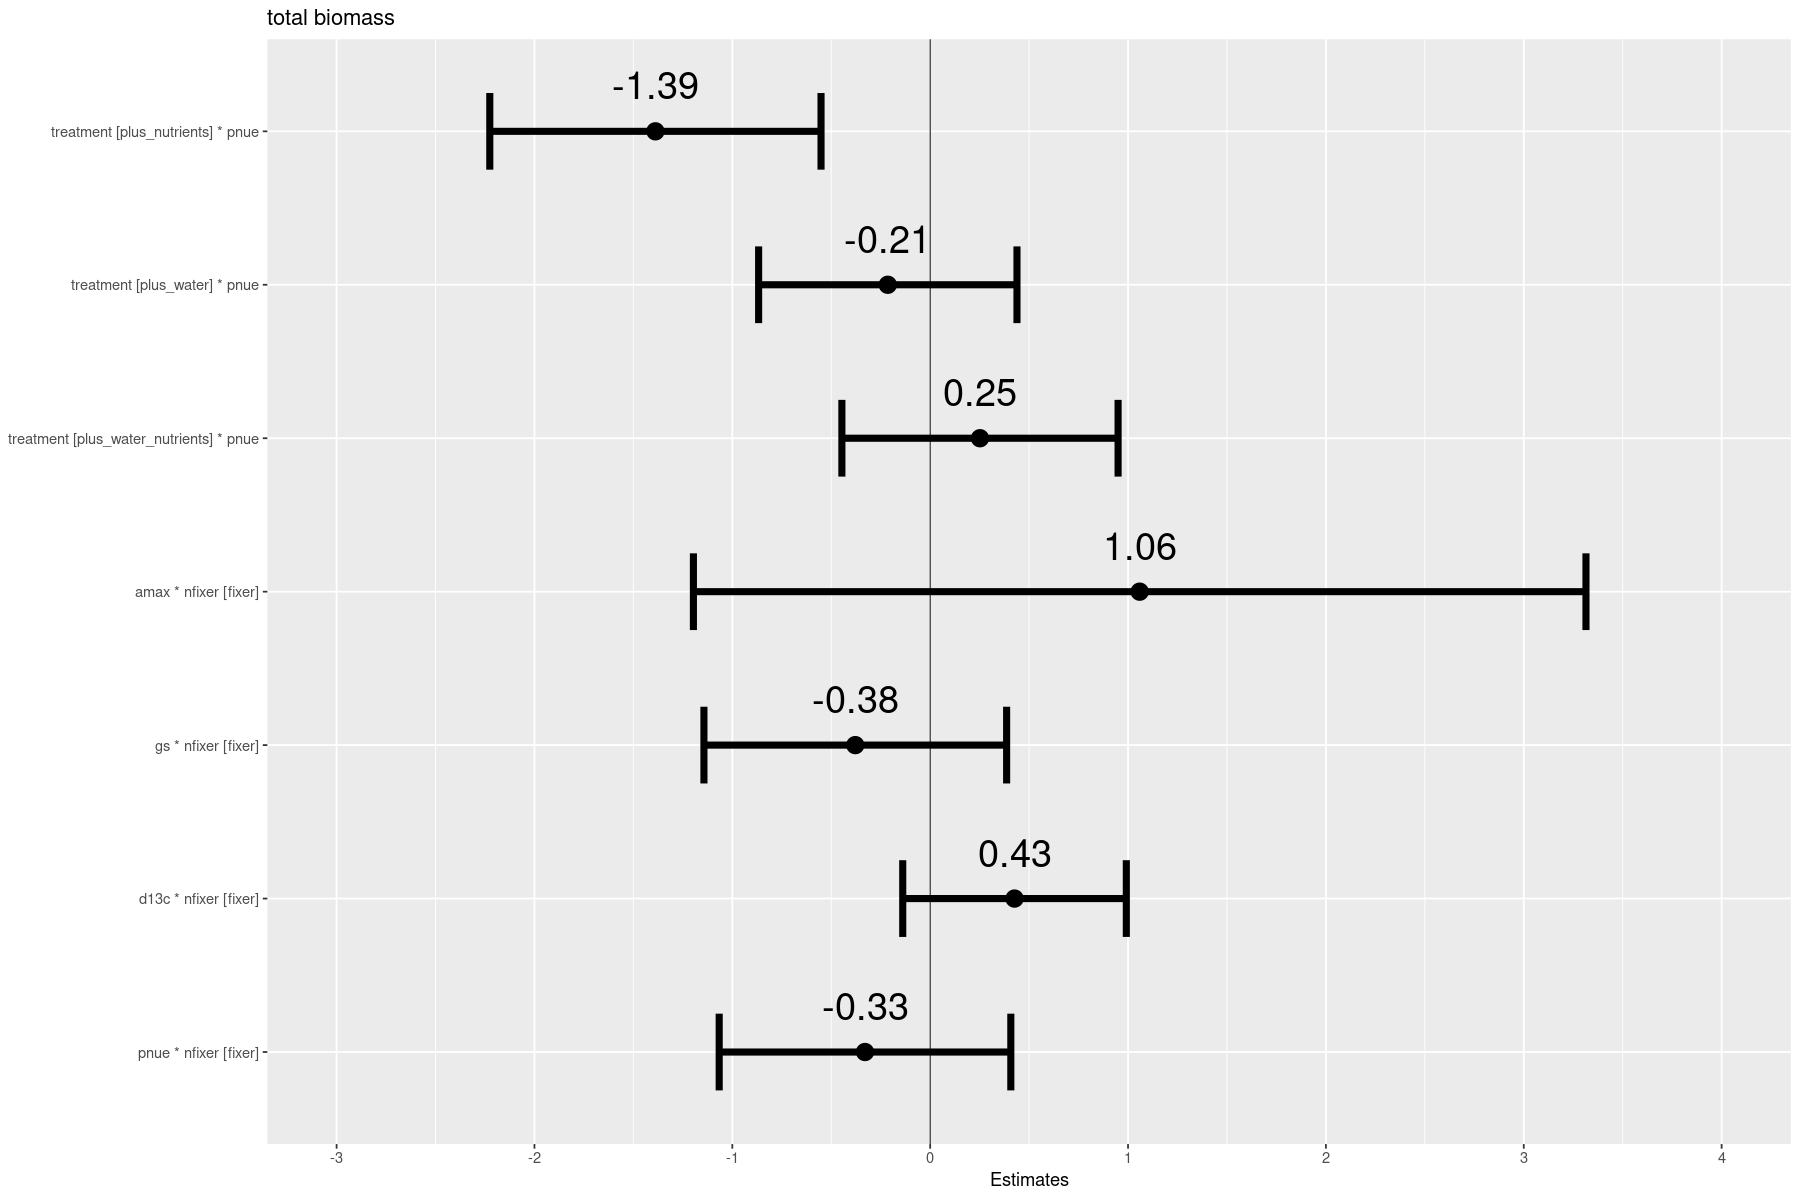

In [46]:
plot_model(model_pc_total_biomass, show.values = TRUE,

                        rm.terms = c("treatmentplus_nutrients",
                                    "treatmentplus_water",
                                    "treatmentplus_water_nutrients",
                                    "amax", "gs", "d13c",
                                    "pnue", "init_height",

                                    "nfixerfixer",

                                     "treatmentplus_nutrients:amax",
                                     "treatmentplus_water:amax",
                                     "treatmentplus_water_nutrients:amax",

                                     "treatmentplus_nutrients:gs",
                                     "treatmentplus_water:gs",
                                     "treatmentplus_water_nutrients:gs",

                                     "treatmentplus_nutrients:d13c",
                                     "treatmentplus_water:d13c",
                                     "treatmentplus_water_nutrients:d13c",

                                     "treatmentplus_nutrients:pnue",
                                     "treatmentplus_water:pnue",
                                     "treatmentplus_water_nutrients:pnue"


                        ),
                        colors = "black",
                        value.offset = .3,
                        value.size = 8,
                        dot.size = 4.5,
                        line.size = 2,
                        vline.color = "black",
                        width = 0.5,
                        show.p = FALSE,

                        )

### RGR 

In [621]:
Anova(model_pc_rgr, type = "III", test.statistic = c("F"))

,F,Df,Df.res,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),2.2881116,1,15.34605,0.1506879830
treatment,0.7935143,3,78.58487,0.5011232717
nfixer,1.9575305,1,10.31708,0.1911161242
pc1,0.1902546,1,82.16043,0.6638488248
pc2,0.8749331,1,81.75383,0.3523480039
pc3,0.5281833,1,82.29216,0.4694339758
scale(init_height),16.6437907,1,75.72873,0.0001105262
treatment:nfixer,1.5937352,3,80.17147,0.1973904391
treatment:pc1,0.6288064,3,78.20842,0.5985680287


#### Amax

In [48]:
emtrends(model_pc_rgr,
        pairwise ~ amax*treatment,
        var = "amax")$contrast %>%
        kable()



|contrast                                                                                    |   estimate|        SE|       df|   lower.CL|  upper.CL|   t.ratio|   p.value|
|:-------------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|---------:|---------:|---------:|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_nutrients)         | -0.0008931| 0.0004534| 405.0045| -0.0020627| 0.0002765| -1.969886| 0.2011501|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_water)             |  0.0002796| 0.0002730| 403.9750| -0.0004246| 0.0009839|  1.024294| 0.7353055|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_water_nutrients)   | -0.0003793| 0.0002663| 406.4248| -0.0010663| 0.0003076| -1.424509| 0.4847331|
|(amax-0.00277714125138734 plus_nutrients) - (amax-0.00277714125138734 plus_water)           |  0.0011727| 0.0004497| 404.5281|  0.00

#### gs

In [49]:
emtrends(model_pc_rgr,
        pairwise ~ gs*treatment,
        var = "gs")$contrast %>%
        kable()



|contrast                                                                                |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:---------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|(gs-0.00451570905042949 no_additions) - (gs-0.00451570905042949 plus_nutrients)         | -0.0002824| 0.0005238| 403.3736| -0.0016337|  0.0010689| -0.5391635| 0.9493994|
|(gs-0.00451570905042949 no_additions) - (gs-0.00451570905042949 plus_water)             | -0.0014975| 0.0004133| 404.5924| -0.0025638| -0.0004313| -3.6231527| 0.0018570|
|(gs-0.00451570905042949 no_additions) - (gs-0.00451570905042949 plus_water_nutrients)   | -0.0003055| 0.0003163| 404.1022| -0.0011214|  0.0005103| -0.9660841| 0.7688126|
|(gs-0.00451570905042949 plus_nutrients) - (gs-0.00451570905042949 plus_water)           | -0.0012151| 0.0004986| 403.5317| -0.0025014|  0.0000

#### d13c

In [50]:
emtrends(model_pc_rgr,
        pairwise ~ d13c*treatment,
        var = "d13c")$contrast %>%
        kable()



|contrast                                                                                  |   estimate|        SE|       df|   lower.CL|  upper.CL|    t.ratio|   p.value|
|:-----------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|---------:|----------:|---------:|
|(d13c-0.0311804624367142 no_additions) - (d13c-0.0311804624367142 plus_nutrients)         | -0.0002024| 0.0002467| 404.3998| -0.0008389| 0.0004340| -0.8204919| 0.8447707|
|(d13c-0.0311804624367142 no_additions) - (d13c-0.0311804624367142 plus_water)             | -0.0004663| 0.0002241| 404.6557| -0.0010444| 0.0001117| -2.0810759| 0.1610311|
|(d13c-0.0311804624367142 no_additions) - (d13c-0.0311804624367142 plus_water_nutrients)   | -0.0001747| 0.0002000| 404.2958| -0.0006906| 0.0003412| -0.8735710| 0.8185436|
|(d13c-0.0311804624367142 plus_nutrients) - (d13c-0.0311804624367142 plus_water)           | -0.0002639| 0.0002522| 403.0913| -0.0009146| 

#### PNUE

In [52]:
emtrends(model_pc_rgr,
        pairwise ~ pnue*treatment,
        var = "pnue")$contrast %>%
        kable()



|contrast                                                                              |   estimate|        SE|       df|   lower.CL|  upper.CL|    t.ratio|   p.value|
|:-------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|---------:|----------:|---------:|
|pnue0.00179582118045257 no_additions - pnue0.00179582118045257 plus_nutrients         |  0.0004444| 0.0003141| 404.2186| -0.0003659| 0.0012546|  1.4147538| 0.4908200|
|pnue0.00179582118045257 no_additions - pnue0.00179582118045257 plus_water             |  0.0003025| 0.0002457| 405.9219| -0.0003313| 0.0009363|  1.2312018| 0.6073531|
|pnue0.00179582118045257 no_additions - pnue0.00179582118045257 plus_water_nutrients   |  0.0000620| 0.0002616| 403.5922| -0.0006129| 0.0007369|  0.2370277| 0.9953085|
|pnue0.00179582118045257 plus_nutrients - pnue0.00179582118045257 plus_water           | -0.0001419| 0.0003334| 405.2429| -0.0010021| 0.0007183| -0.4254710| 0

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


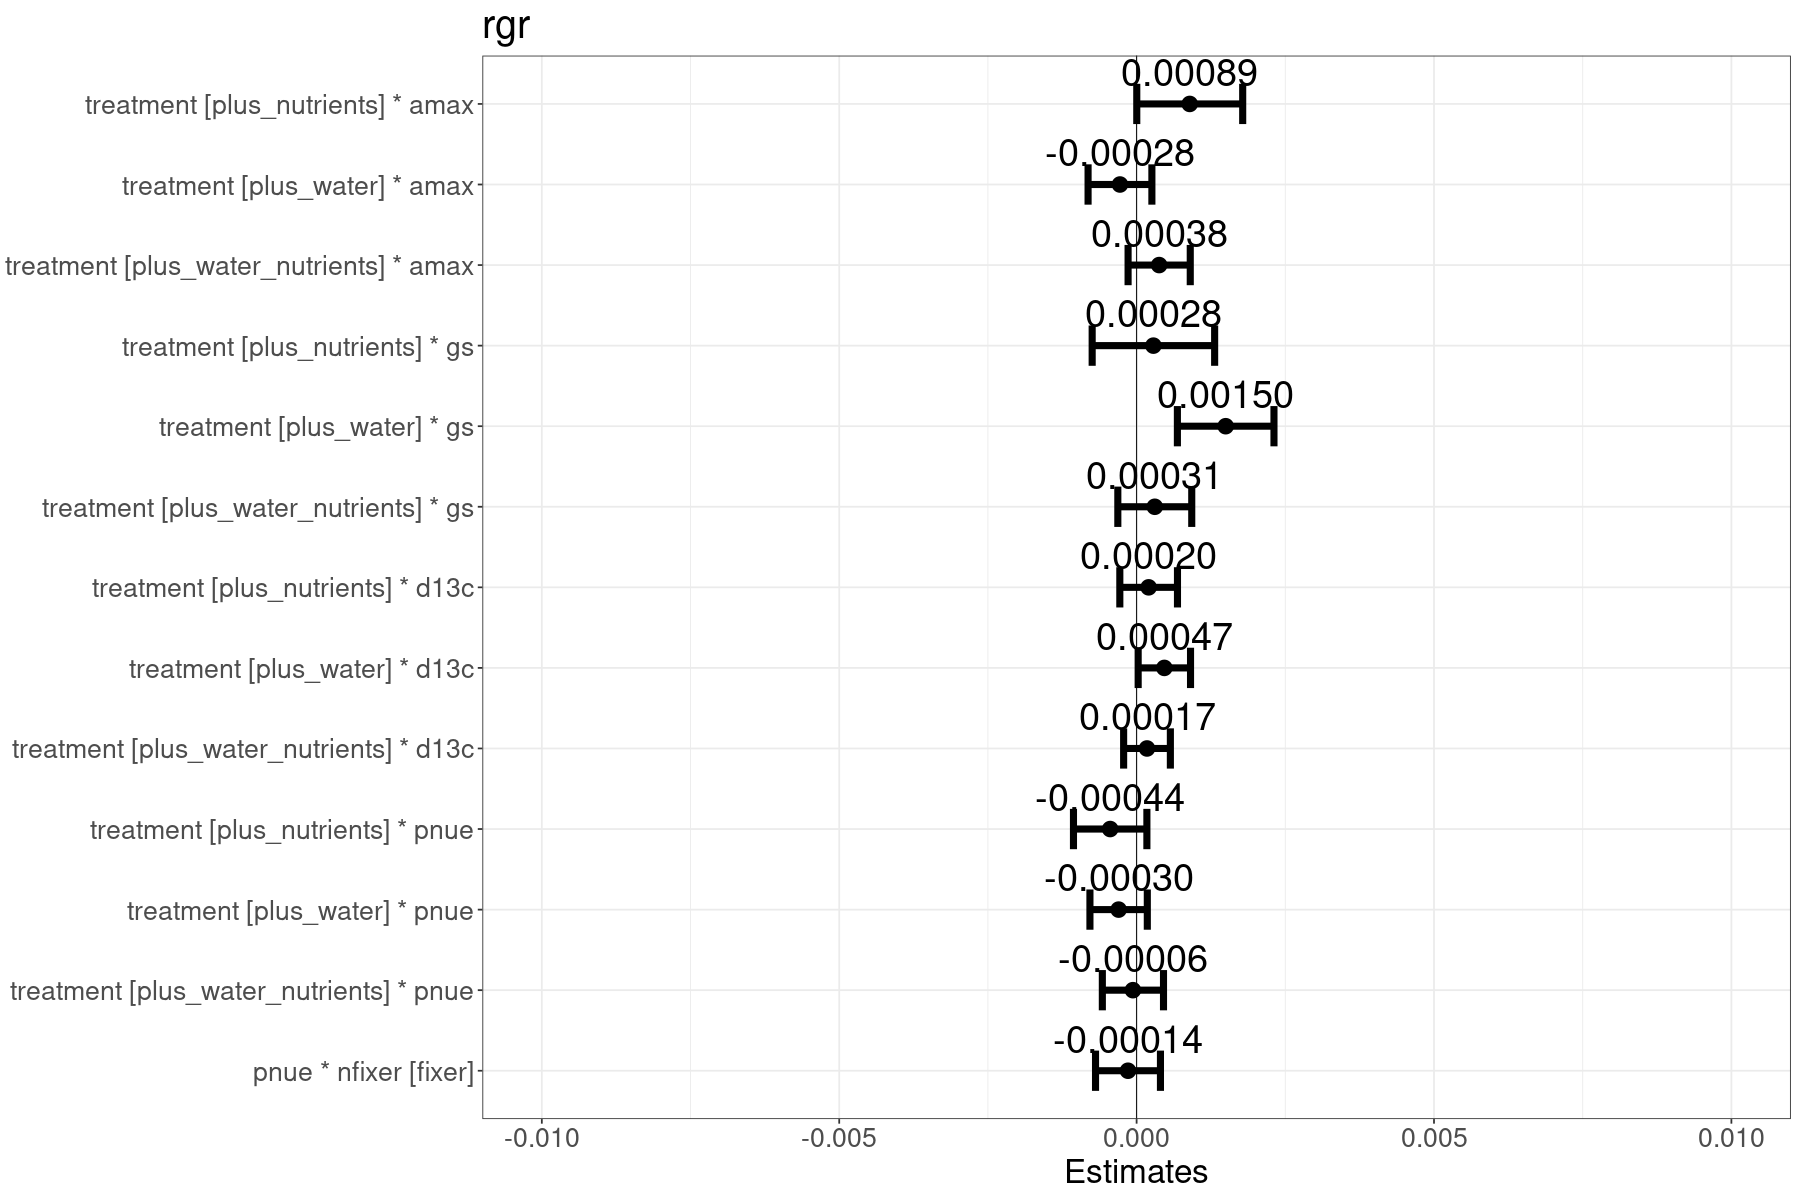

In [53]:
plot_model(model_pc_rgr, show.values = TRUE,

                        rm.terms = c("treatmentplus_nutrients","treatmentplus_water",
                                    "treatmentplus_water_nutrients",
                                    "amax", "gs", "d13c", "pnue", "init_height",
                                    "nfixerfixer", "amax:nfixerfixer",
                                    "gs:nfixerfixer", "d13c:nfixerfixer",
                                    "pnue:nfixerfixer"),
                        colors = "black",
                        value.offset = .4,
                        value.size = 8,
                        dot.size = 4,
                        line.size = 2,
                        vline.color = "black",
                        width = 0.5,
                        show.p = FALSE,
                        digits = 5

                        ) +
                        theme_bw() +
                        theme(text = element_text(size = 20)) +
                        ylim(-0.01,0.01)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


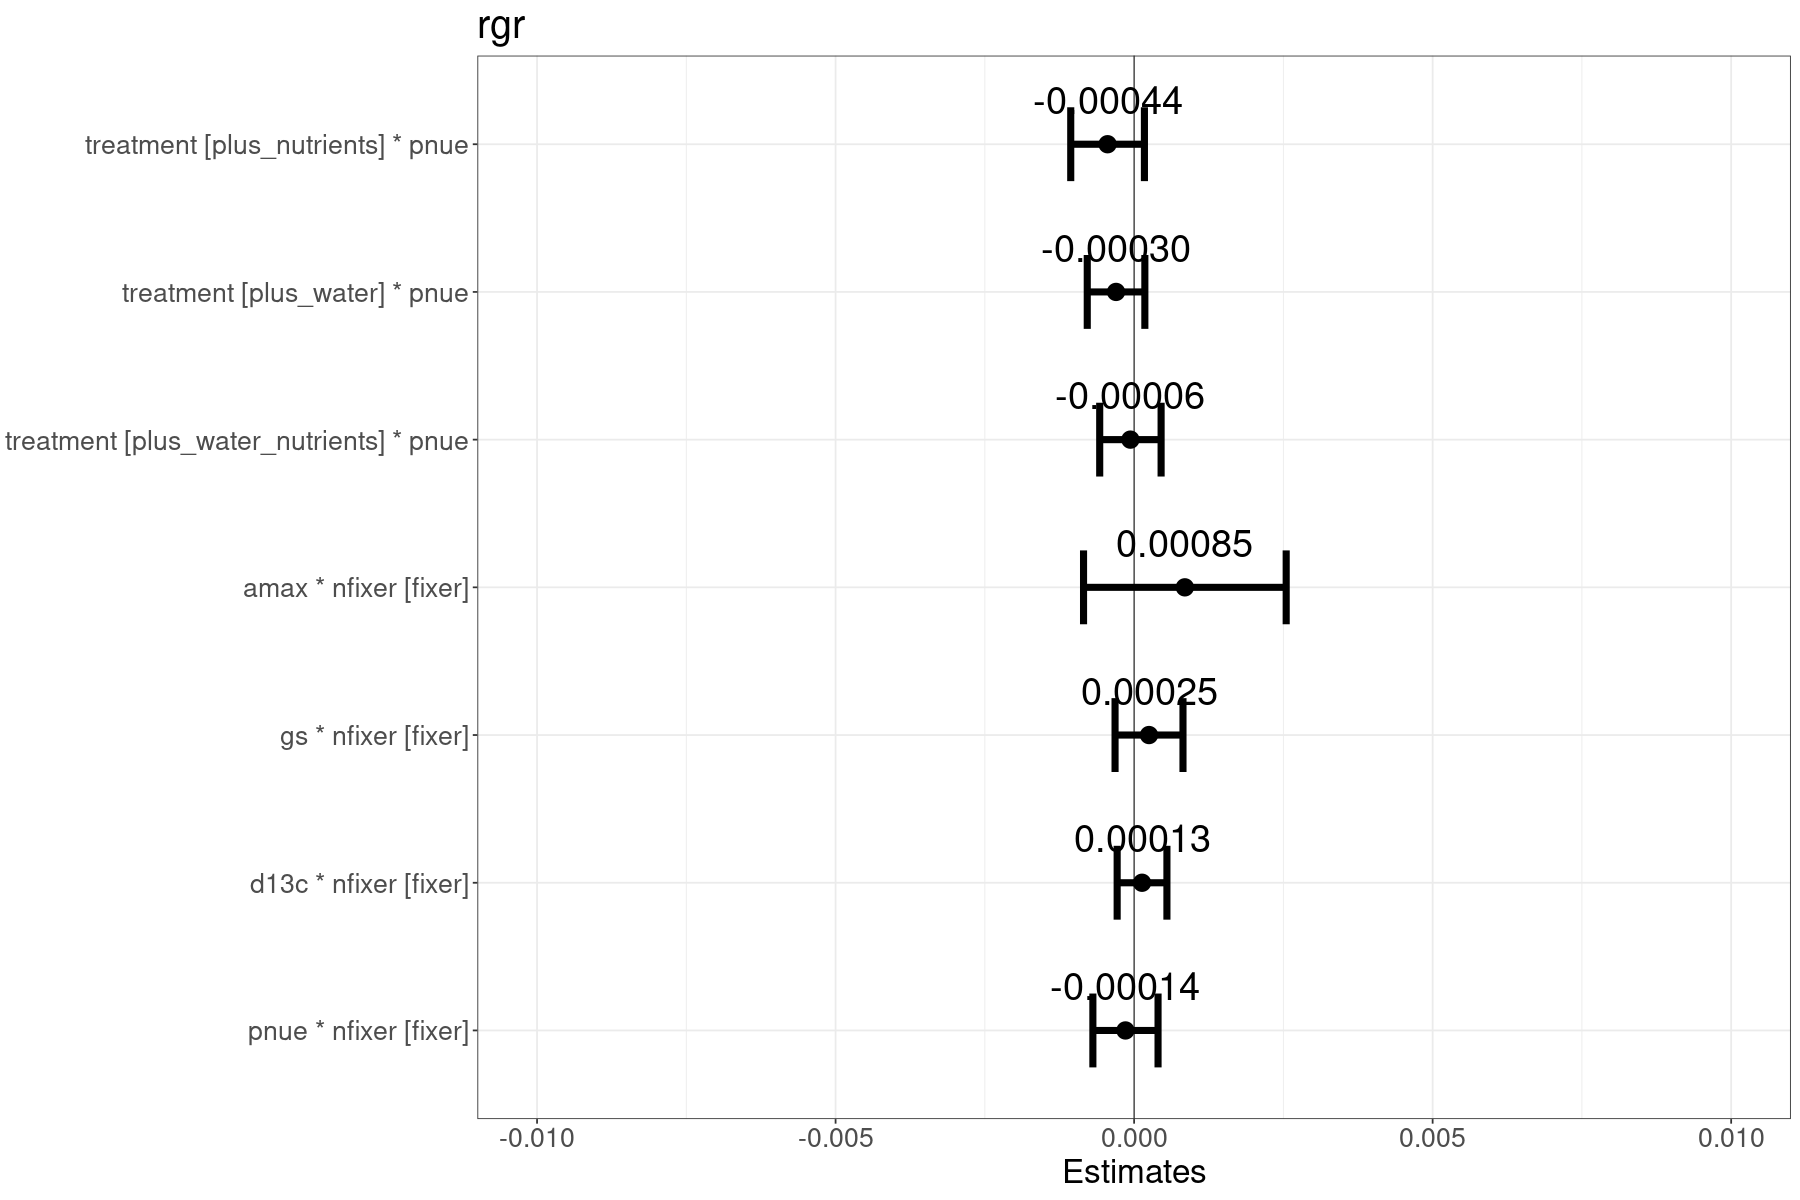

In [54]:
plot_model(model_pc_rgr, show.values = TRUE,

                        rm.terms = c("treatmentplus_nutrients",
                                    "treatmentplus_water",
                                    "treatmentplus_water_nutrients",
                                    "amax", "gs", "d13c",
                                    "pnue", "init_height",

                                    "nfixerfixer",

                                     "treatmentplus_nutrients:amax",
                                     "treatmentplus_water:amax",
                                     "treatmentplus_water_nutrients:amax",



                                     "treatmentplus_nutrients:gs",
                                     "treatmentplus_water:gs",
                                     "treatmentplus_water_nutrients:gs",

                                     "treatmentplus_nutrients:d13c",
                                     "treatmentplus_water:d13c",
                                     "treatmentplus_water_nutrients:d13c",

                                     "treatmentplus_nutrients:pnue",
                                     "treatmentplus_water:pnue",
                                     "treatmentplus_water_nutrients:pnue"


                        ),
                        colors = "black",
                        value.offset = .3,
                        value.size = 8,
                        dot.size = 4.5,
                        line.size = 2,
                        vline.color = "black",
                        width = 0.5,
                        show.p = FALSE,
                        digits = 5

                        ) +
                        theme_bw() +
                        theme(text = element_text(size = 20)) +
                        ylim(-0.01,0.01)

### Root to shoot ratio 

In [624]:
Anova(model_pc_root_shoot, type = "III", test.statistic = c("F"))

,F,Df,Df.res,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),10.82007221,1,11.300833,0.006970046
treatment,0.97241079,3,78.350488,0.410120641
nfixer,0.94933149,1,8.646249,0.356358206
pc1,0.59638630,1,80.842198,0.442211972
pc2,0.16764626,1,80.560621,0.683298804
pc3,1.03426560,1,80.979827,0.312187760
scale(init_height),0.06310828,1,83.153678,0.802268710
treatment:nfixer,4.09426633,3,79.468451,0.009342689
treatment:pc1,1.32991599,3,78.117139,0.270692650


#### Amax

In [56]:
emtrends(model_pc_root_shoot,
        pairwise ~ amax*treatment,
        var = "amax")$contrast %>%
        kable()



|contrast                                                                                    |   estimate|        SE|       df|   lower.CL|   upper.CL|   t.ratio|   p.value|
|:-------------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|----------:|---------:|---------:|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_nutrients)         | -0.4664135| 0.0864436| 404.3256| -0.6894161| -0.2434109| -5.395581| 0.0000007|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_water)             | -0.2567512| 0.0520450| 403.6198| -0.3910150| -0.1224874| -4.933258| 0.0000070|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_water_nutrients)   | -0.1833433| 0.0507838| 405.3540| -0.3143512| -0.0523354| -3.610273| 0.0019463|
|(amax-0.00277714125138734 plus_nutrients) - (amax-0.00277714125138734 plus_water)           |  0.2096623| 0.0857324| 404.0083| 

#### gs

In [57]:
emtrends(model_pc_root_shoot,
        pairwise ~ gs*treatment,
        var = "gs")$contrast %>%
        kable()



|contrast                                                                                |   estimate|        SE|       df|   lower.CL|  upper.CL|    t.ratio|   p.value|
|:---------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|---------:|----------:|---------:|
|(gs-0.00451570905042949 no_additions) - (gs-0.00451570905042949 plus_nutrients)         |  0.2381908| 0.0998565| 403.2332| -0.0194165| 0.4957982|  2.3853313| 0.0815236|
|(gs-0.00451570905042949 no_additions) - (gs-0.00451570905042949 plus_water)             |  0.0800069| 0.0788026| 404.0372| -0.1232844| 0.2832982|  1.0152823| 0.7405894|
|(gs-0.00451570905042949 no_additions) - (gs-0.00451570905042949 plus_water_nutrients)   |  0.0564985| 0.0602926| 403.7013| -0.0990421| 0.2120391|  0.9370720| 0.7849117|
|(gs-0.00451570905042949 plus_nutrients) - (gs-0.00451570905042949 plus_water)           | -0.1581839| 0.0950545| 403.3417| -0.4034028| 0.0870350| -

#### d13c

In [58]:
emtrends(model_pc_root_shoot,
        pairwise ~ d13c*treatment,
        var = "d13c")$contrast %>%
        kable()



|contrast                                                                                  |   estimate|        SE|       df|   lower.CL|   upper.CL|   t.ratio|   p.value|
|:-----------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|----------:|---------:|---------:|
|(d13c-0.0311804624367142 no_additions) - (d13c-0.0311804624367142 plus_nutrients)         |  0.1770022| 0.0470366| 403.9193|  0.0556592|  0.2983452|  3.763073| 0.0011015|
|(d13c-0.0311804624367142 no_additions) - (d13c-0.0311804624367142 plus_water)             |  0.0879497| 0.0427247| 404.0994| -0.0222694|  0.1981688|  2.058521| 0.1686612|
|(d13c-0.0311804624367142 no_additions) - (d13c-0.0311804624367142 plus_water_nutrients)   |  0.0093232| 0.0381254| 403.8519| -0.0890311|  0.1076775|  0.244540| 0.9948551|
|(d13c-0.0311804624367142 plus_nutrients) - (d13c-0.0311804624367142 plus_water)           | -0.0890525| 0.0480842| 403.0563| -0.2130991| 

#### PNUE

In [59]:
emtrends(model_pc_root_shoot,
        pairwise ~ pnue*treatment,
        var = "pnue")$contrast %>%
        kable()



|contrast                                                                              |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:-------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|pnue0.00179582118045257 no_additions - pnue0.00179582118045257 plus_nutrients         |  0.1969485| 0.0598803| 403.7773|  0.0424715|  0.3514254|  3.2890349| 0.0059993|
|pnue0.00179582118045257 no_additions - pnue0.00179582118045257 plus_water             |  0.0083926| 0.0468496| 404.9865| -0.1124666|  0.1292518|  0.1791397| 0.9979563|
|pnue0.00179582118045257 no_additions - pnue0.00179582118045257 plus_water_nutrients   |  0.0174529| 0.0498758| 403.3815| -0.1112152|  0.1461210|  0.3499275| 0.9852749|
|pnue0.00179582118045257 plus_nutrients - pnue0.00179582118045257 plus_water           | -0.1885559| 0.0635804| 404.5045| -0.3525769| -0.0245348| -2.9656

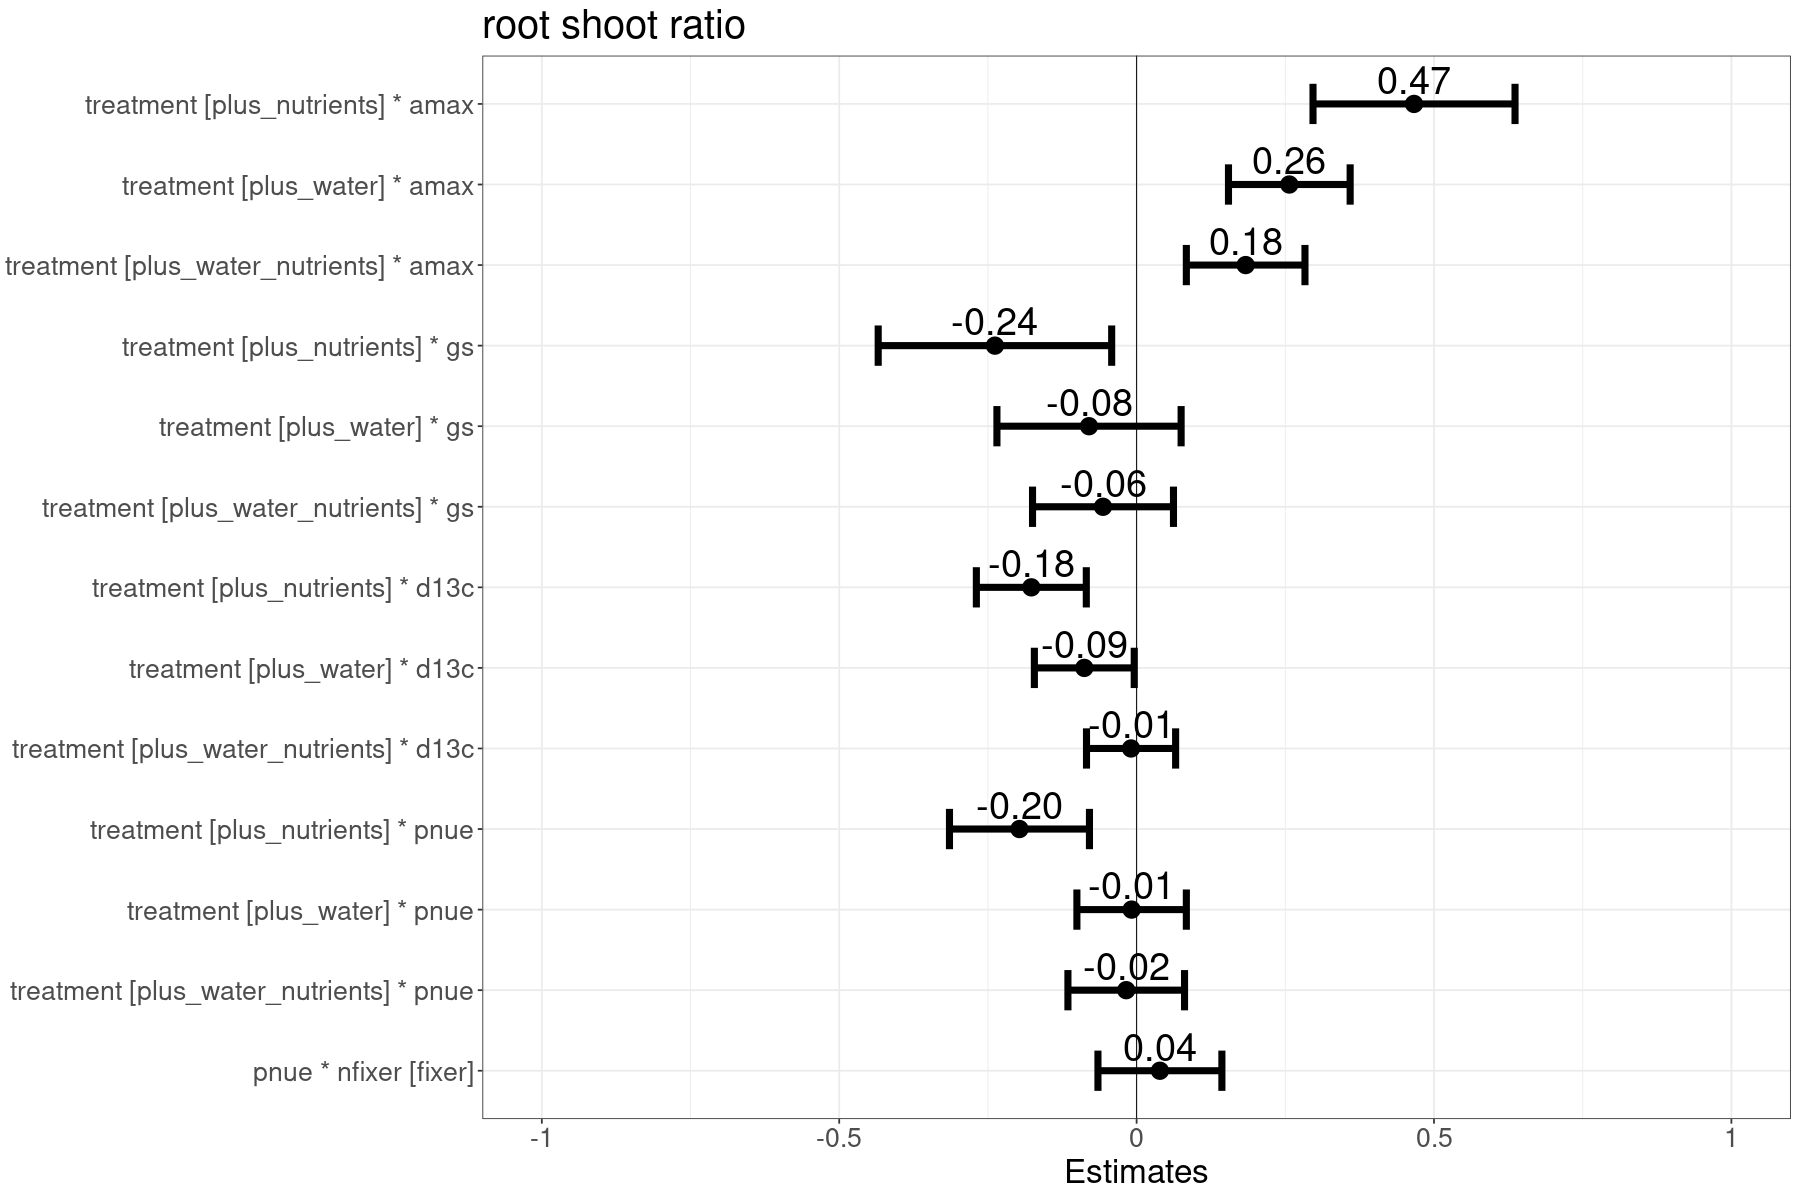

In [60]:
plot_model(model_pc_root_shoot, show.values = TRUE,

                        rm.terms = c("treatmentplus_nutrients","treatmentplus_water",
                                    "treatmentplus_water_nutrients",
                                    "amax", "gs", "d13c", "pnue", "init_height",
                                    "nfixerfixer", "amax:nfixerfixer",
                                    "gs:nfixerfixer", "d13c:nfixerfixer",
                                    "pnue:nfixerfixer"
                                    ),
                        colors = "black",
                        value.offset = .3,
                        value.size = 8,
                        dot.size = 4.5,
                        line.size = 2,
                        vline.color = "black",
                        width = 0.5,
                        show.p = FALSE,

                        ) +
                        theme_bw() +
                        theme(text = element_text(size = 20))

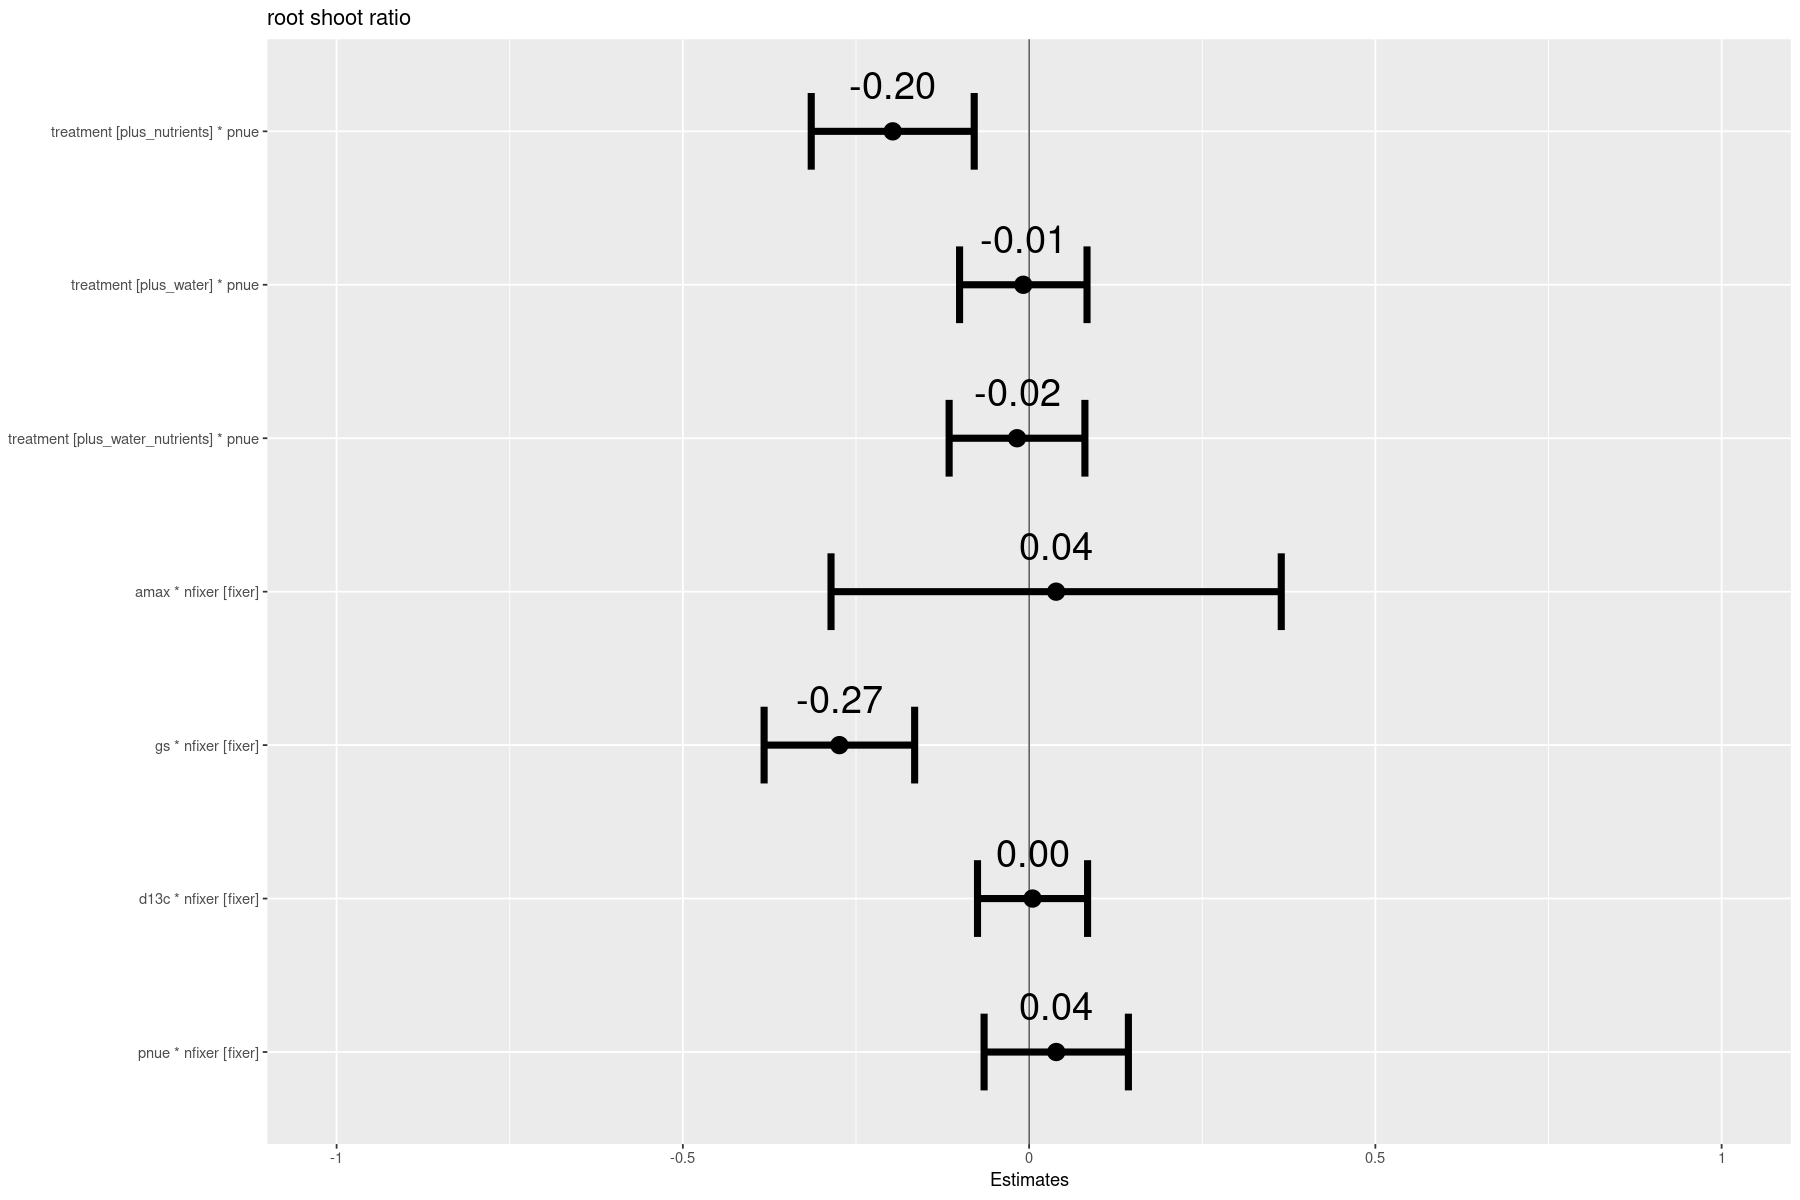

In [61]:
plot_model(model_pc_root_shoot, show.values = TRUE,

                        rm.terms = c("treatmentplus_nutrients",
                                    "treatmentplus_water",
                                    "treatmentplus_water_nutrients",
                                    "amax", "gs", "d13c",
                                    "pnue", "init_height",

                                    "nfixerfixer",

                                     "treatmentplus_nutrients:amax",
                                     "treatmentplus_water:amax",
                                     "treatmentplus_water_nutrients:amax",

                                     "treatmentplus_nutrients:gs",
                                     "treatmentplus_water:gs",
                                     "treatmentplus_water_nutrients:gs",

                                     "treatmentplus_nutrients:d13c",
                                     "treatmentplus_water:d13c",
                                     "treatmentplus_water_nutrients:d13c",

                                     "treatmentplus_nutrients:pnue",
                                     "treatmentplus_water:pnue",
                                     "treatmentplus_water_nutrients:pnue"


                        ),
                        colors = "black",
                        value.offset = .3,
                        value.size = 8,
                        dot.size = 4.5,
                        line.size = 2,
                        vline.color = "black",
                        width = 0.5,
                        show.p = FALSE,

                        )